In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import os
import datetime

start_time = datetime.datetime.now() 
print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2024-06-15 15:49:12.275419


# Ensure you have a graphics card, otherwise the training time will be excessively long

In [2]:
device = torch.device("cuda:0")
print(torch.cuda.is_available())

True


# Set fixed random seed to ensure reproducible results

In [3]:
def set_seed(seed):
    # --- Set random seed
    random.seed(seed)
    np.random.seed(seed)
    # --- Ensure consistency in hash behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    # --- Setting the workspace configuration of cuBLAS
    """
    By setting the workspace configuration of cuBLAS, 
    specific workspace sizes and algorithm combinations are ensured when running deep learning models, 
    thereby maintaining consistency of results.
    """
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # --- Make the random numbers generated on the CPU repeatable
    torch.manual_seed(seed)
    # --- Make the random numbers generated on a single GPU repeatable
    torch.cuda.manual_seed(seed)
    # --- Make the random numbers generated on multiple GPUs repeatable
    torch.cuda.manual_seed_all(seed)
    # --- Using deterministic algorithms ensures consistency and repeatability of calculation results across different runs
    torch.use_deterministic_algorithms(True)
    # --- Set the cuDNN backend to deterministic mode to ensure the use of deterministic algorithms
    """
    Certain operations (such as convolution) produce the same result in multiple runs.
    """
    torch.backends.cudnn.deterministic = True
    # --- Disable cuDNN using non deterministic algorithms
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

set_seed(2024)

# Define a function for calculating accuracy

In [4]:
def get_clean_acc(model, data_loader, model_device):
    model.eval()
    correct = 0
    total = 0
    
    for data, labels in data_loader:
        data, labels = data.to(model_device), labels.to(model_device)
        with torch.no_grad():
            logits = model(data)
            prediction = torch.argmax(logits, 1)
            ground_truth = labels
            total += labels.size(0)
            correct += (prediction == ground_truth).sum().item()
            
    accuracy = correct / total
    print(f"Total:{total}  Correct:{correct}  CleanAccuracy:{accuracy:.4f}")
    return accuracy

# Define a function for training the model

In [5]:
def train(model_device,
          model,
          model_optimizer, 
          train_set, validate_set,
          epochs=200,
          classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
         ):
    train_loss_list = []
    validate_loss_list = []
    best_acc = -np.Inf
    
    # --- Define Scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=model_optimizer, milestones=[60, 120, 180], last_epoch=0 - 1)
    
    # --- Train
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        validate_loss = 0.0
        model.train()
        count = 0
        for dataset_train, dataset_train_labels in train_set:
            count = count + 1
            dataset_train, dataset_train_labels = dataset_train.to(model_device), dataset_train_labels.to(model_device)
            
            logits = model(dataset_train)

            model_optimizer.zero_grad()
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_train_labels)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            torch.cuda.empty_cache()
        train_loss_list.append(train_loss / count)
        if scheduler is not None:
            scheduler.step()
        
        # --- Validate
        model.eval()
        count = 0
        for dataset_validate, dataset_validate_labels in validate_set:
            count = count + 1
            dataset_validate, dataset_validate_labels = dataset_validate.to(model_device), dataset_validate_labels.to(model_device)

            with torch.no_grad():
                logits = model(dataset_validate)
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_validate_labels)

            validate_loss += loss.item()
            torch.cuda.empty_cache()
        validate_loss_list.append(validate_loss / count)
        
        # --- Show results
        model.eval()
        end_time = datetime.datetime.now()
        time = end_time - start_time
        print(f"Epoch:{epoch}\nTime:{time}\nLoss:{validate_loss / count}")           
        acc = get_clean_acc(model, validate_set, model_device)
        torch.cuda.empty_cache()
        
        # --- Save best model parameters
        if not os.path.exists("./best_params/mnist/wrn_28_10"):
            os.makedirs("./best_params/mnist/wrn_28_10")
        if acc >= best_acc:
            path = os.path.join("./best_params/mnist/wrn_28_10", f"wrn_28_10_params_{epoch}.pth")
            #torch.save(model.module.state_dict(), path)   # Enable during multi-GPUs training
            torch.save(model.state_dict(), path)           # Enable during single GPU training
            best_acc = acc
       
        # --- Visualize loss
        if epoch != 0:
            fig = plt.figure(figsize=(5, 5))
            x = range(0, len(validate_loss_list))
            y1 = train_loss_list
            y2 = validate_loss_list
            plt.plot(x, y1, label="Train Loss")
            plt.plot(x, y2, label="Validate Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            if not os.path.exists("./best_params/mnist/wrn_28_10/loss_curve"):
                os.makedirs("./best_params/mnist/wrn_28_10/loss_curve")
            path = os.path.join("./best_params/mnist/wrn_28_10/loss_curve", f"loss_curve_{epoch}.png")
            plt.savefig(path, bbox_inches='tight', dpi=500)
            plt.show()

# Load the dataset

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4, padding_mode="edge"),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="./data",
                                       train=True,
                                       transform=transform_train,
                                       download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)

test_set = torchvision.datasets.MNIST(root="./data",
                                      train=False,
                                      transform=transform_test,
                                      download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1)
 
print("size=", len(train_loader))
print("size=", len(test_loader))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████| 9912422/9912422 [07:25<00:00, 22257.36it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 102708.20it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:04<00:00, 381384.16it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

size= 1875
size= 313


# Load the model

In [7]:
from model_zoo.wide_resnet import wideresnet_28_10_mnist
net = wideresnet_28_10_mnist()
net = net.to(device)

# Define Optimizer

In [8]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Begin to train

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch:0
Time:0:11:24.335178
Loss:0.08902060100139259
Total:10000  Correct:9707  CleanAccuracy:0.9707


  0%|▍                                                                             | 1/200 [03:55<12:59:33, 235.04s/it]

Epoch:1
Time:0:15:19.238019
Loss:0.06766029642898583
Total:10000  Correct:9790  CleanAccuracy:0.9790


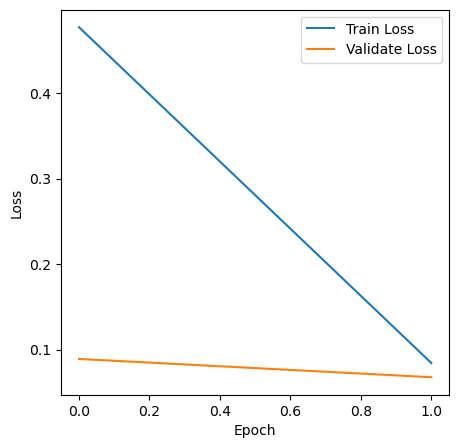

  1%|▊                                                                             | 2/200 [07:50<12:56:43, 235.37s/it]

Epoch:2
Time:0:19:14.799214
Loss:0.044889440167525684
Total:10000  Correct:9853  CleanAccuracy:0.9853


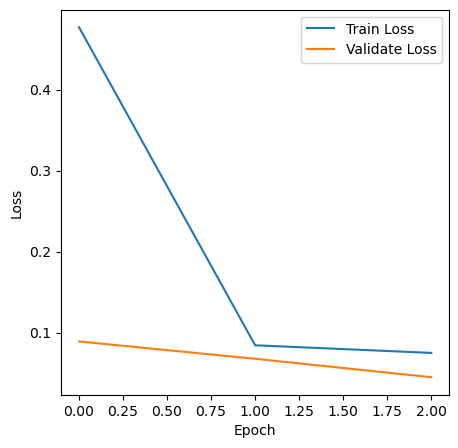

  2%|█▏                                                                            | 3/200 [11:46<12:52:52, 235.39s/it]

Epoch:3
Time:0:23:11.328308
Loss:0.1653349502235294
Total:10000  Correct:9505  CleanAccuracy:0.9505


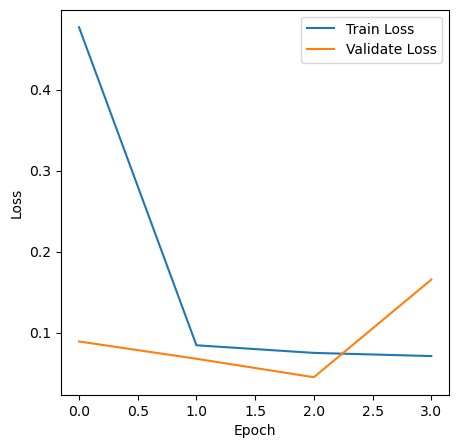

  2%|█▌                                                                            | 4/200 [15:42<12:50:02, 235.73s/it]

Epoch:4
Time:0:27:06.286201
Loss:0.06292019420048257
Total:10000  Correct:9811  CleanAccuracy:0.9811


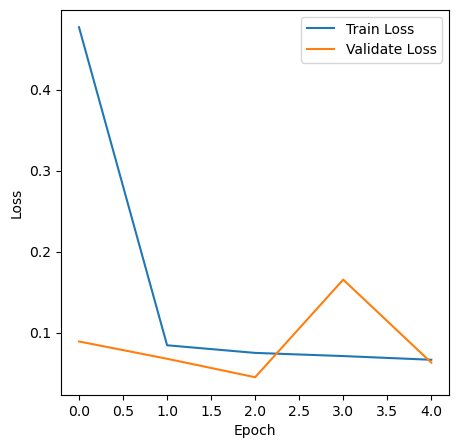

  2%|█▉                                                                            | 5/200 [19:37<12:45:15, 235.46s/it]

Epoch:5
Time:0:31:00.932959
Loss:0.0566680934004926
Total:10000  Correct:9834  CleanAccuracy:0.9834


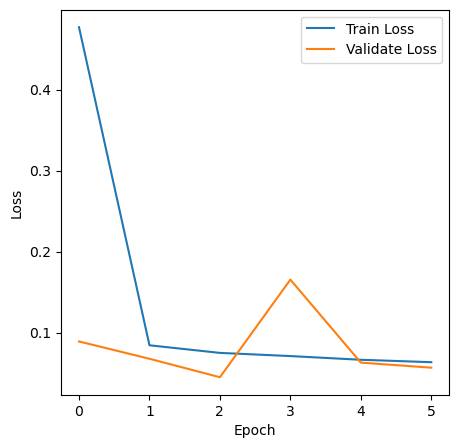

  3%|██▎                                                                           | 6/200 [23:32<12:40:45, 235.29s/it]

Epoch:6
Time:0:34:56.126824
Loss:0.05366265339689097
Total:10000  Correct:9823  CleanAccuracy:0.9823


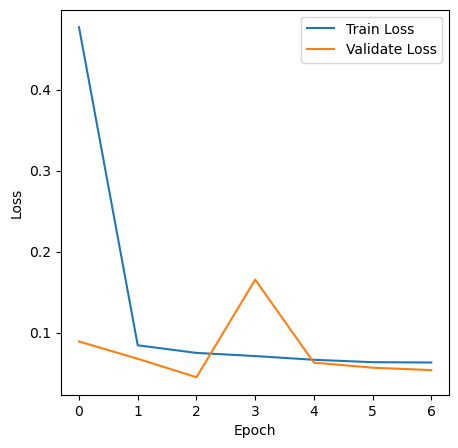

  4%|██▋                                                                           | 7/200 [27:25<12:34:37, 234.60s/it]

Epoch:7
Time:0:38:49.781913
Loss:0.07160912422569671
Total:10000  Correct:9797  CleanAccuracy:0.9797


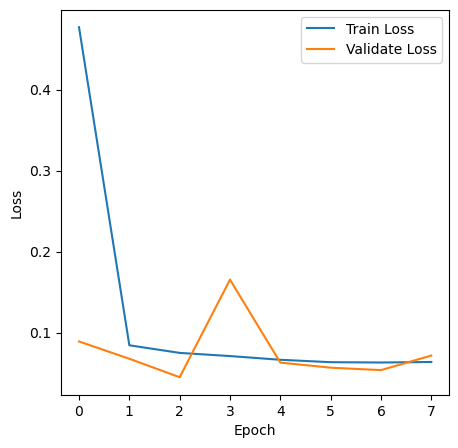

  4%|███                                                                           | 8/200 [31:20<12:31:36, 234.88s/it]

Epoch:8
Time:0:42:44.933896
Loss:0.4738549963829997
Total:10000  Correct:8300  CleanAccuracy:0.8300


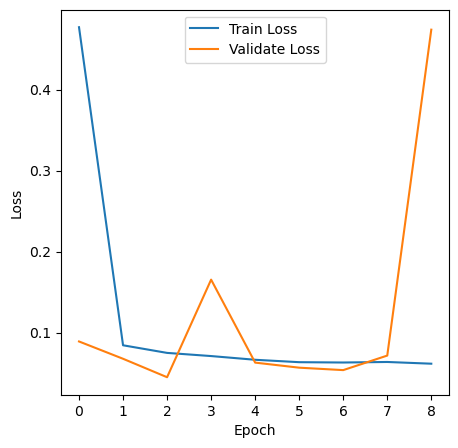

  4%|███▌                                                                          | 9/200 [35:15<12:27:52, 234.93s/it]

Epoch:9
Time:0:46:39.599731
Loss:0.044862627731572936
Total:10000  Correct:9849  CleanAccuracy:0.9849


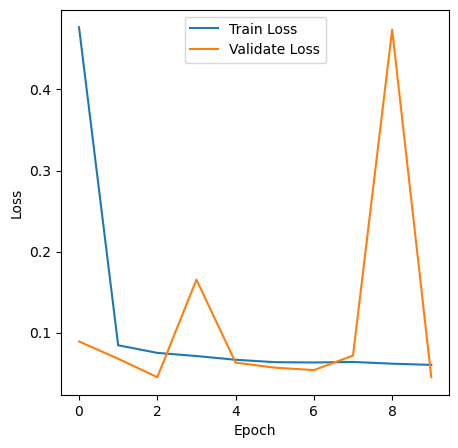

  5%|███▊                                                                         | 10/200 [39:10<12:23:31, 234.79s/it]

Epoch:10
Time:0:50:34.118199
Loss:0.031832475011469796
Total:10000  Correct:9902  CleanAccuracy:0.9902


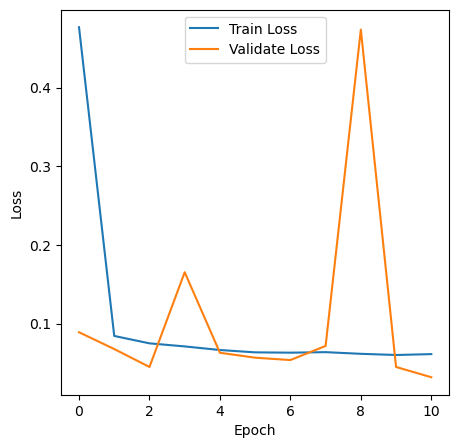

  6%|████▏                                                                        | 11/200 [43:05<12:19:44, 234.84s/it]

Epoch:11
Time:0:54:29.957937
Loss:0.04627691798812945
Total:10000  Correct:9862  CleanAccuracy:0.9862


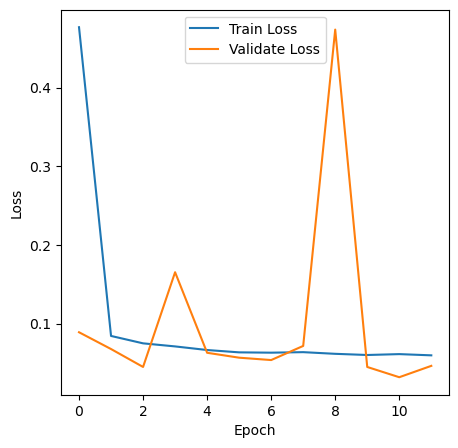

  6%|████▌                                                                        | 12/200 [47:00<12:16:32, 235.07s/it]

Epoch:12
Time:0:58:25.990077
Loss:0.03934802645945716
Total:10000  Correct:9883  CleanAccuracy:0.9883


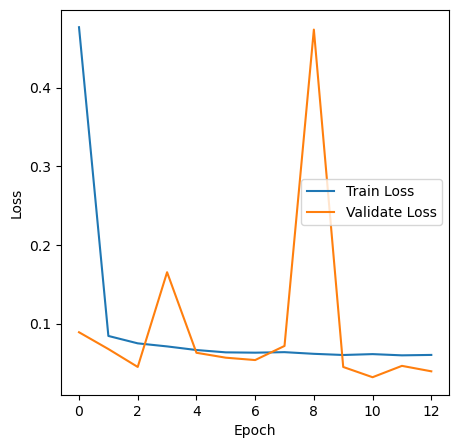

  6%|█████                                                                        | 13/200 [50:58<12:15:12, 235.90s/it]

Epoch:13
Time:1:02:23.199006
Loss:0.04736691574787739
Total:10000  Correct:9857  CleanAccuracy:0.9857


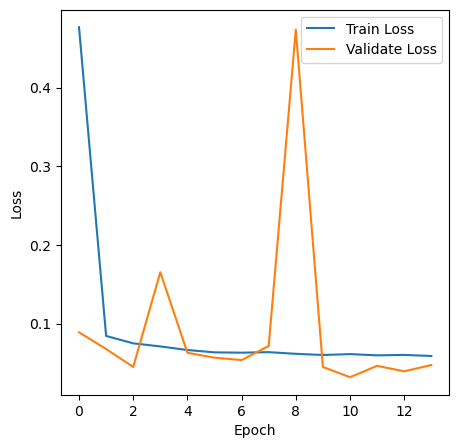

  7%|█████▍                                                                       | 14/200 [54:54<12:10:50, 235.75s/it]

Epoch:14
Time:1:06:18.274033
Loss:0.16325496801118644
Total:10000  Correct:9516  CleanAccuracy:0.9516


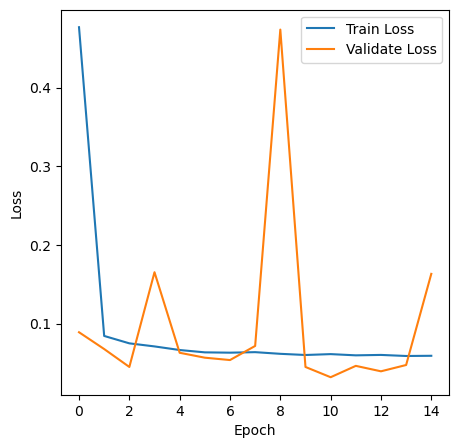

  8%|█████▊                                                                       | 15/200 [58:49<12:06:17, 235.55s/it]

Epoch:15
Time:1:10:14.036957
Loss:0.04759249206410703
Total:10000  Correct:9853  CleanAccuracy:0.9853


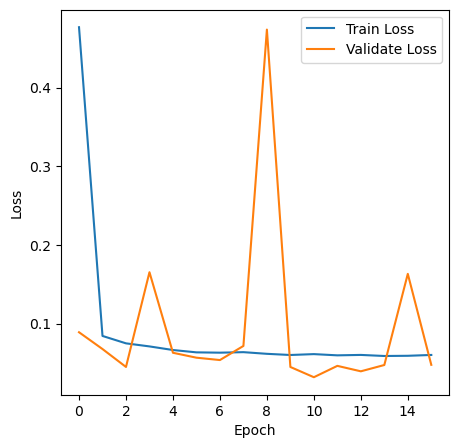

  8%|██████                                                                     | 16/200 [1:02:45<12:02:37, 235.64s/it]

Epoch:16
Time:1:14:12.538007
Loss:0.062541045560747
Total:10000  Correct:9807  CleanAccuracy:0.9807


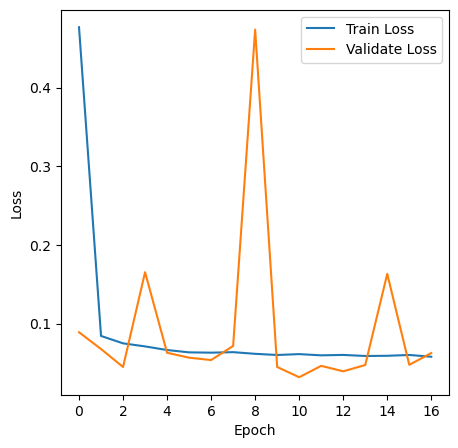

  8%|██████▍                                                                    | 17/200 [1:06:43<12:01:15, 236.48s/it]

Epoch:17
Time:1:18:08.718742
Loss:0.05975309781341132
Total:10000  Correct:9812  CleanAccuracy:0.9812


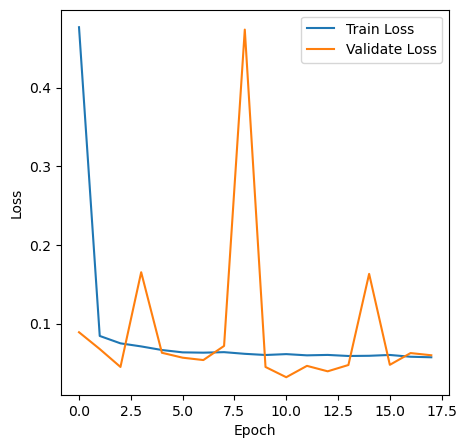

  9%|██████▊                                                                    | 18/200 [1:10:39<11:57:03, 236.39s/it]

Epoch:18
Time:1:22:04.493291
Loss:0.04502121380616959
Total:10000  Correct:9857  CleanAccuracy:0.9857


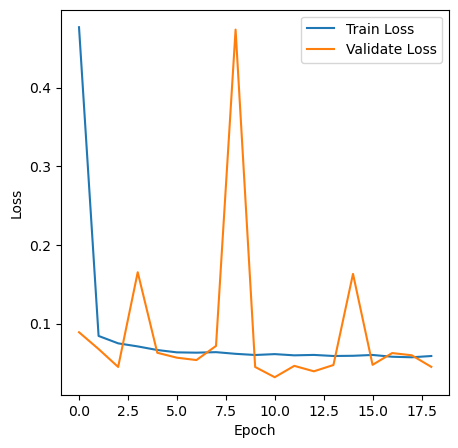

 10%|███████▏                                                                   | 19/200 [1:14:35<11:52:38, 236.23s/it]

Epoch:19
Time:1:25:59.945878
Loss:0.0434112453311771
Total:10000  Correct:9869  CleanAccuracy:0.9869


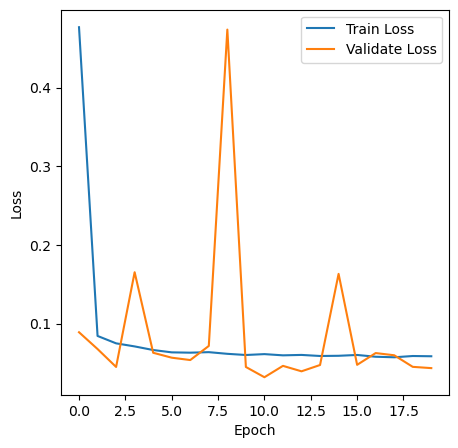

 10%|███████▌                                                                   | 20/200 [1:18:31<11:48:09, 236.05s/it]

Epoch:20
Time:1:29:55.332942
Loss:0.12498686224231109
Total:10000  Correct:9639  CleanAccuracy:0.9639


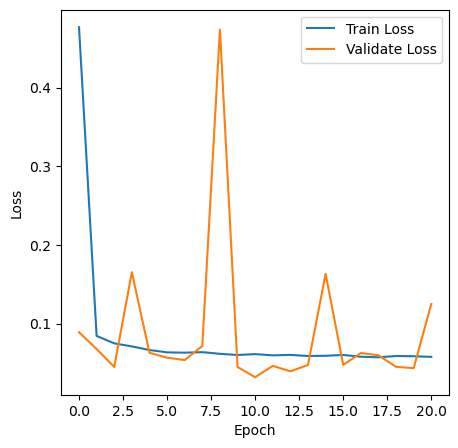

 10%|███████▉                                                                   | 21/200 [1:22:26<11:43:28, 235.80s/it]

Epoch:21
Time:1:33:50.740298
Loss:0.052200488318442206
Total:10000  Correct:9857  CleanAccuracy:0.9857


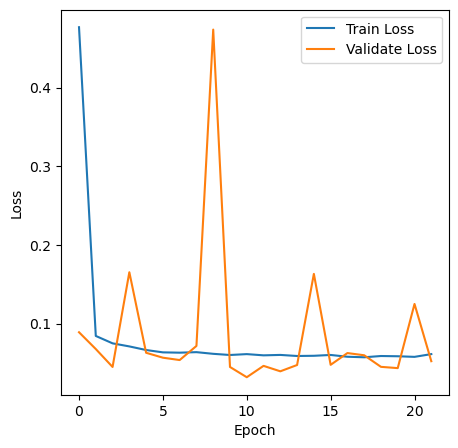

 11%|████████▎                                                                  | 22/200 [1:26:21<11:39:03, 235.64s/it]

Epoch:22
Time:1:38:06.244331
Loss:0.14238602880718776
Total:10000  Correct:9535  CleanAccuracy:0.9535


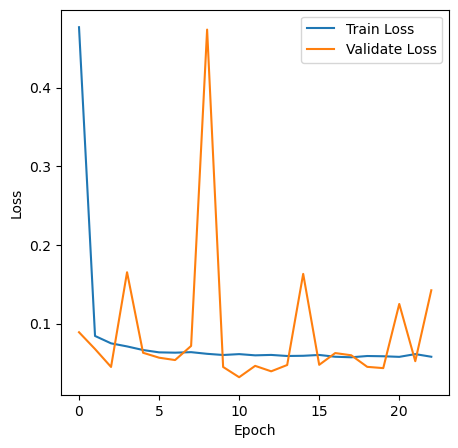

 12%|████████▋                                                                  | 23/200 [1:30:37<11:52:50, 241.64s/it]

Epoch:23
Time:1:42:11.756612
Loss:0.0597569665745289
Total:10000  Correct:9806  CleanAccuracy:0.9806


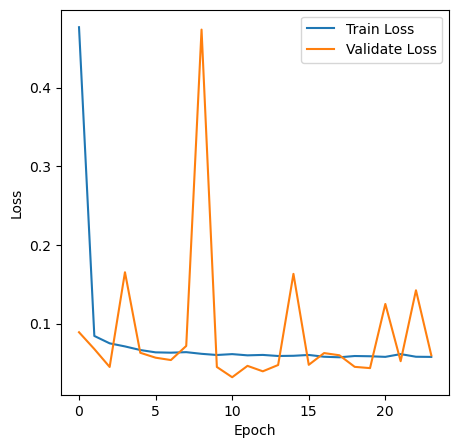

 12%|█████████                                                                  | 24/200 [1:34:42<11:52:06, 242.77s/it]

Epoch:24
Time:1:46:15.957426
Loss:0.06553403740286078
Total:10000  Correct:9804  CleanAccuracy:0.9804


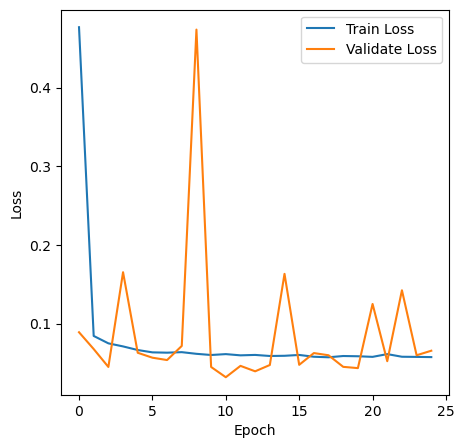

 12%|█████████▍                                                                 | 25/200 [1:38:46<11:49:20, 243.20s/it]

Epoch:25
Time:1:50:19.395553
Loss:0.0676624509407365
Total:10000  Correct:9803  CleanAccuracy:0.9803


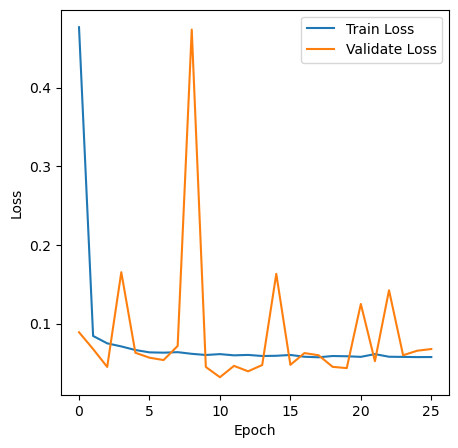

 13%|█████████▊                                                                 | 26/200 [1:42:50<11:45:24, 243.24s/it]

Epoch:26
Time:1:54:23.057839
Loss:0.05457689181214181
Total:10000  Correct:9827  CleanAccuracy:0.9827


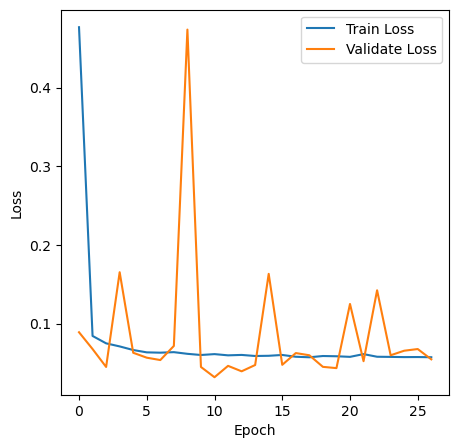

 14%|██████████▏                                                                | 27/200 [1:46:53<11:41:38, 243.34s/it]

Epoch:27
Time:1:58:27.747657
Loss:0.04757305505661705
Total:10000  Correct:9869  CleanAccuracy:0.9869


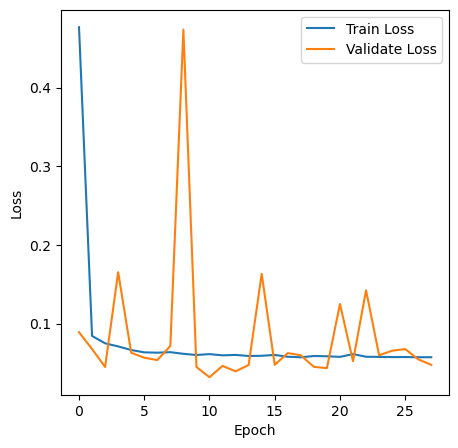

 14%|██████████▌                                                                | 28/200 [1:50:58<11:38:48, 243.77s/it]

Epoch:28
Time:2:02:32.344089
Loss:0.04626585581576446
Total:10000  Correct:9863  CleanAccuracy:0.9863


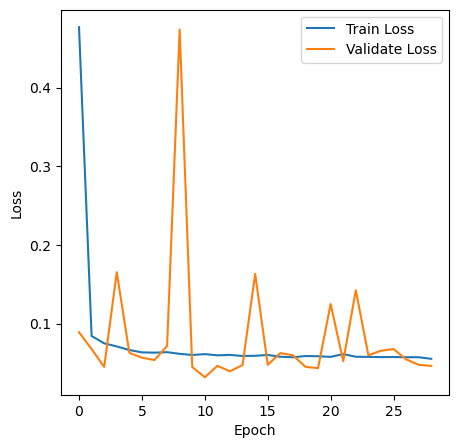

 14%|██████████▉                                                                | 29/200 [1:55:03<11:35:29, 244.03s/it]

Epoch:29
Time:2:06:37.457389
Loss:0.07135583465835585
Total:10000  Correct:9784  CleanAccuracy:0.9784


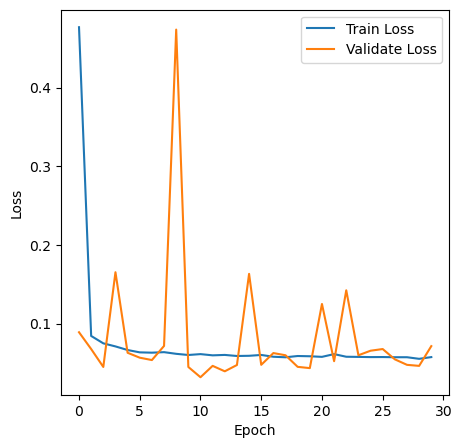

 15%|███████████▎                                                               | 30/200 [1:59:08<11:32:29, 244.41s/it]

Epoch:30
Time:2:10:41.905935
Loss:0.051069973279054784
Total:10000  Correct:9837  CleanAccuracy:0.9837


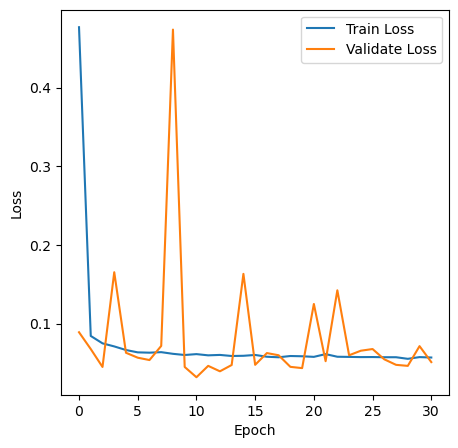

 16%|███████████▋                                                               | 31/200 [2:03:12<11:28:19, 244.37s/it]

Epoch:31
Time:2:14:46.264938
Loss:0.05540434527136504
Total:10000  Correct:9837  CleanAccuracy:0.9837


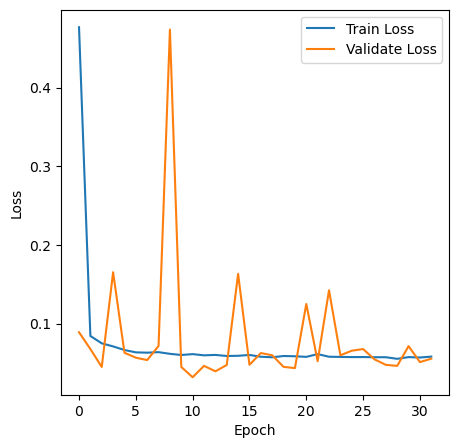

 16%|████████████                                                               | 32/200 [2:07:17<11:24:12, 244.36s/it]

Epoch:32
Time:2:18:55.375201
Loss:0.05475035995879499
Total:10000  Correct:9835  CleanAccuracy:0.9835


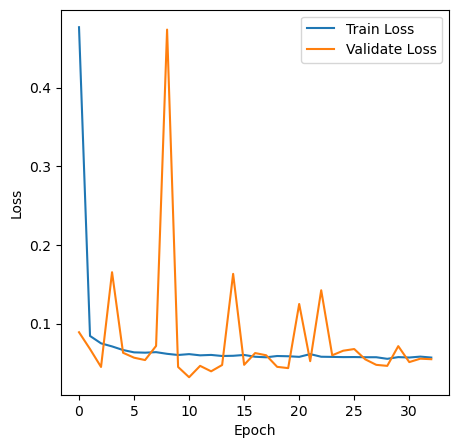

 16%|████████████▍                                                              | 33/200 [2:11:26<11:24:21, 245.88s/it]

Epoch:33
Time:2:23:04.688726
Loss:0.0931071919118859
Total:10000  Correct:9704  CleanAccuracy:0.9704


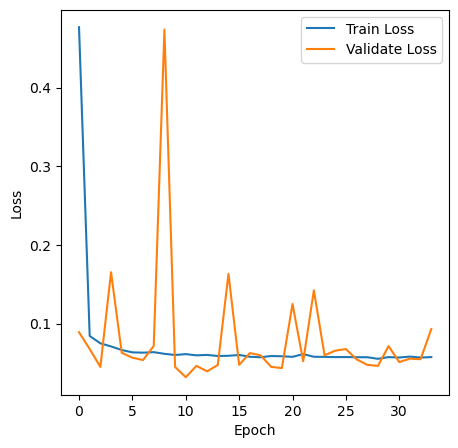

 17%|████████████▊                                                              | 34/200 [2:15:35<11:22:58, 246.86s/it]

Epoch:34
Time:2:27:24.226488
Loss:0.04131688101525112
Total:10000  Correct:9868  CleanAccuracy:0.9868


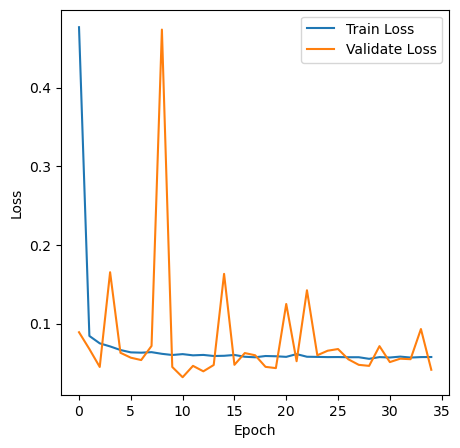

 18%|█████████████▏                                                             | 35/200 [2:19:54<11:28:45, 250.46s/it]

Epoch:35
Time:2:31:31.666107
Loss:0.034380190729372984
Total:10000  Correct:9894  CleanAccuracy:0.9894


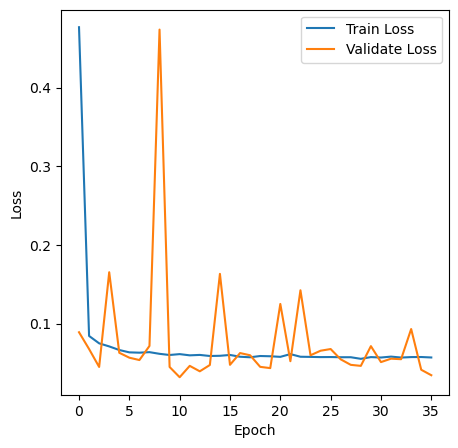

 18%|█████████████▌                                                             | 36/200 [2:24:02<11:22:20, 249.64s/it]

Epoch:36
Time:2:35:40.937362
Loss:0.07375753526564706
Total:10000  Correct:9787  CleanAccuracy:0.9787


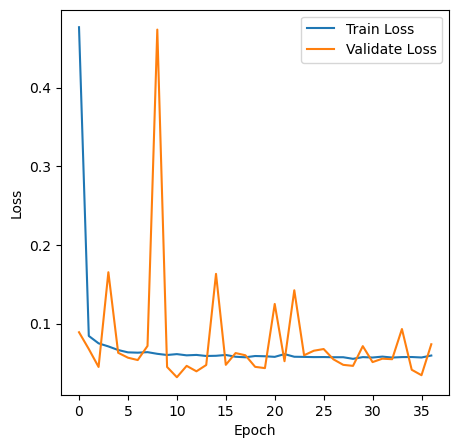

 18%|█████████████▉                                                             | 37/200 [2:28:11<11:17:39, 249.44s/it]

Epoch:37
Time:2:39:50.390474
Loss:0.030955243074885994
Total:10000  Correct:9908  CleanAccuracy:0.9908


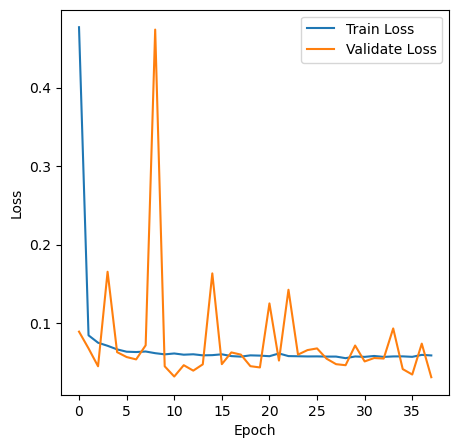

 19%|██████████████▎                                                            | 38/200 [2:32:21<11:14:15, 249.72s/it]

Epoch:38
Time:2:44:00.441363
Loss:0.03278956874044978
Total:10000  Correct:9896  CleanAccuracy:0.9896


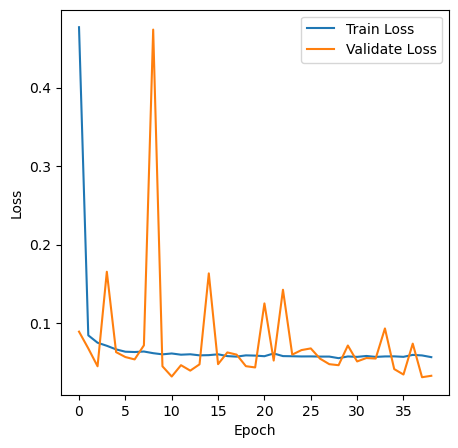

 20%|██████████████▋                                                            | 39/200 [2:36:31<11:10:09, 249.75s/it]

Epoch:39
Time:2:48:10.336352
Loss:0.03206305450800927
Total:10000  Correct:9899  CleanAccuracy:0.9899


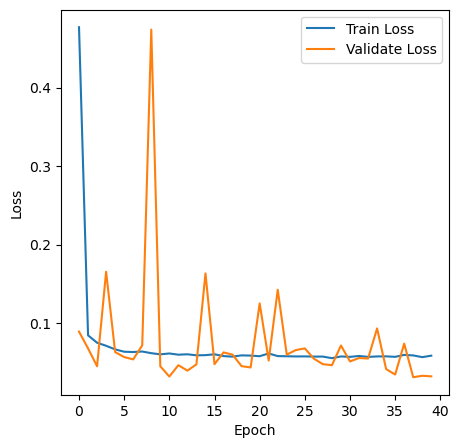

 20%|███████████████                                                            | 40/200 [2:40:41<11:06:06, 249.79s/it]

Epoch:40
Time:2:52:19.732600
Loss:0.0709456867187287
Total:10000  Correct:9788  CleanAccuracy:0.9788


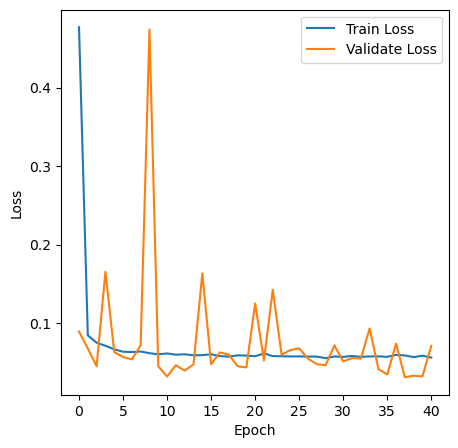

 20%|███████████████▎                                                           | 41/200 [2:44:50<11:01:42, 249.70s/it]

Epoch:41
Time:2:56:29.811143
Loss:0.06932758974259534
Total:10000  Correct:9786  CleanAccuracy:0.9786


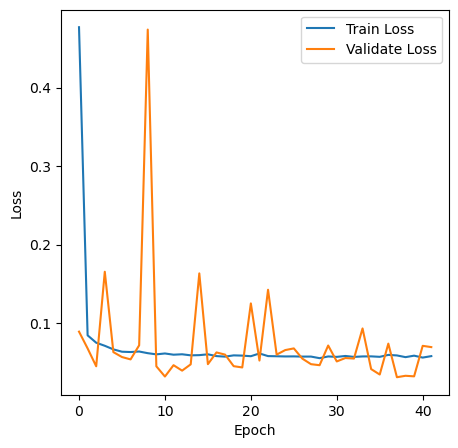

 21%|███████████████▊                                                           | 42/200 [2:49:00<10:57:47, 249.79s/it]

Epoch:42
Time:3:00:46.599796
Loss:0.05885442036773843
Total:10000  Correct:9818  CleanAccuracy:0.9818


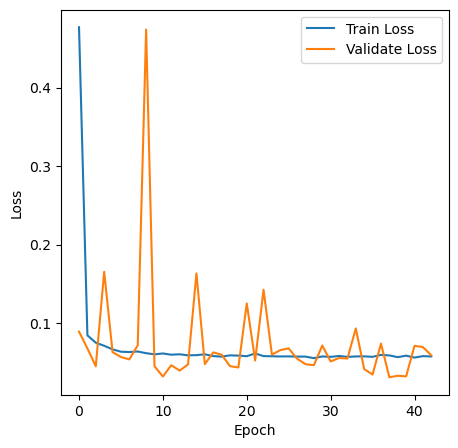

 22%|████████████████▏                                                          | 43/200 [2:53:17<10:59:19, 251.97s/it]

Epoch:43
Time:3:04:58.792616
Loss:0.04311455497226214
Total:10000  Correct:9866  CleanAccuracy:0.9866


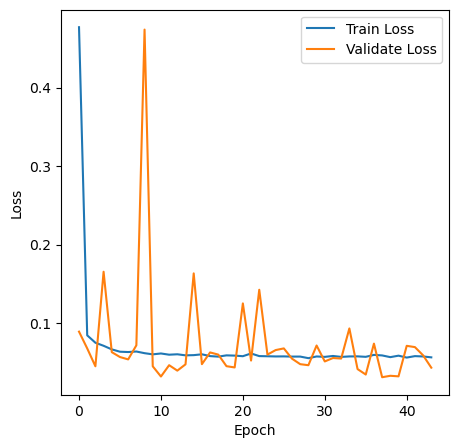

 22%|████████████████▌                                                          | 44/200 [2:57:29<10:54:58, 251.91s/it]

Epoch:44
Time:3:09:12.410246
Loss:0.24418027408587667
Total:10000  Correct:9358  CleanAccuracy:0.9358


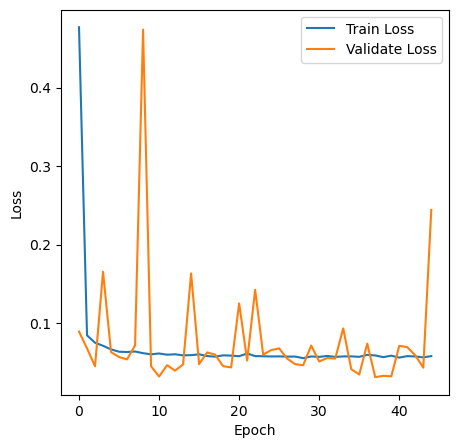

 22%|████████████████▉                                                          | 45/200 [3:01:43<10:52:14, 252.48s/it]

Epoch:45
Time:3:13:47.244208
Loss:0.05652333973195053
Total:10000  Correct:9821  CleanAccuracy:0.9821


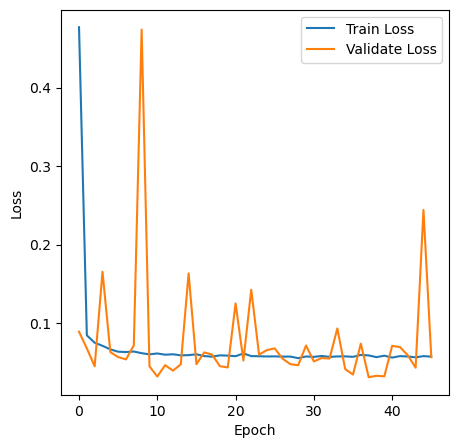

 23%|█████████████████▎                                                         | 46/200 [3:06:18<11:05:11, 259.17s/it]

Epoch:46
Time:3:18:23.132472
Loss:0.04734286943490739
Total:10000  Correct:9856  CleanAccuracy:0.9856


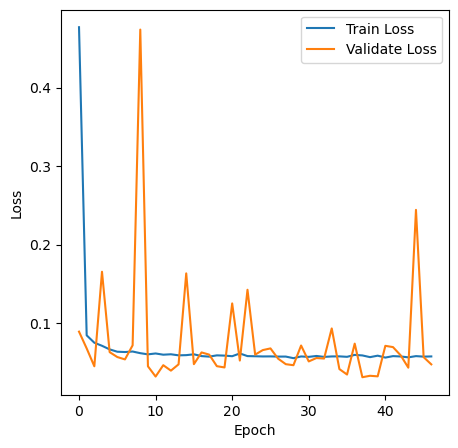

 24%|█████████████████▋                                                         | 47/200 [3:10:54<11:13:48, 264.24s/it]

Epoch:47
Time:3:22:33.232527
Loss:0.06217282625326601
Total:10000  Correct:9789  CleanAccuracy:0.9789


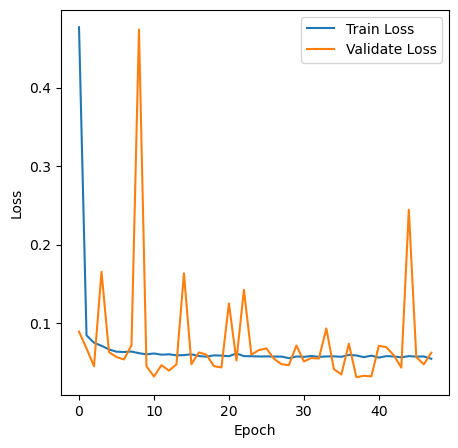

 24%|██████████████████                                                         | 48/200 [3:15:04<10:58:33, 259.96s/it]

Epoch:48
Time:3:26:43.775132
Loss:0.05548519217081892
Total:10000  Correct:9836  CleanAccuracy:0.9836


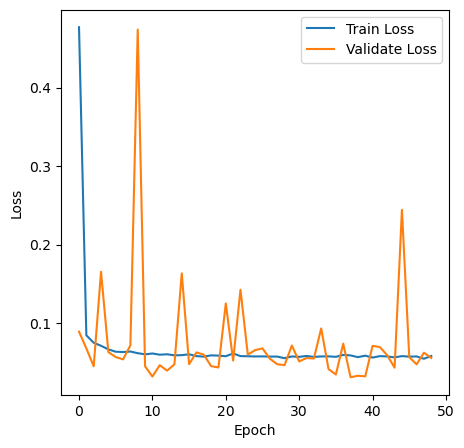

 24%|██████████████████▍                                                        | 49/200 [3:19:14<10:46:44, 256.98s/it]

Epoch:49
Time:3:30:53.272006
Loss:0.04077859266033283
Total:10000  Correct:9867  CleanAccuracy:0.9867


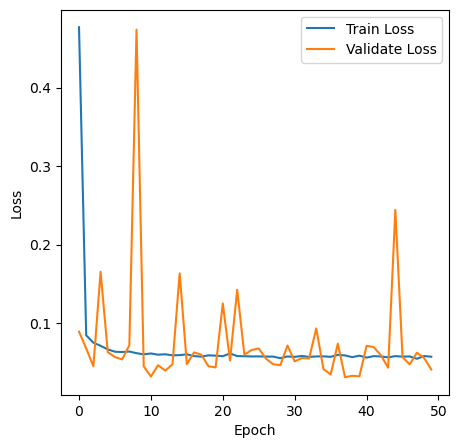

 25%|██████████████████▊                                                        | 50/200 [3:23:26<10:38:36, 255.44s/it]

Epoch:50
Time:3:35:04.045543
Loss:0.026804554972986575
Total:10000  Correct:9916  CleanAccuracy:0.9916


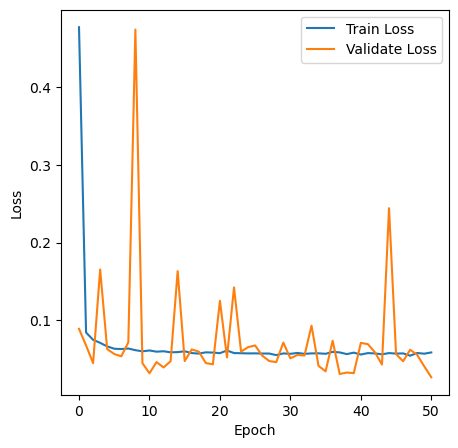

 26%|███████████████████▏                                                       | 51/200 [3:27:35<10:29:39, 253.55s/it]

Epoch:51
Time:3:39:14.008476
Loss:0.04746193991813228
Total:10000  Correct:9851  CleanAccuracy:0.9851


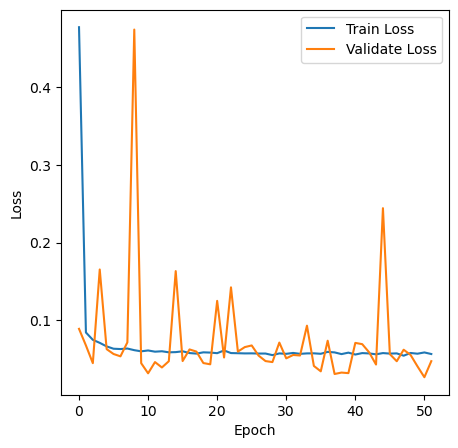

 26%|███████████████████▌                                                       | 52/200 [3:31:45<10:22:33, 252.39s/it]

Epoch:52
Time:3:43:28.401707
Loss:0.05762486672438027
Total:10000  Correct:9834  CleanAccuracy:0.9834


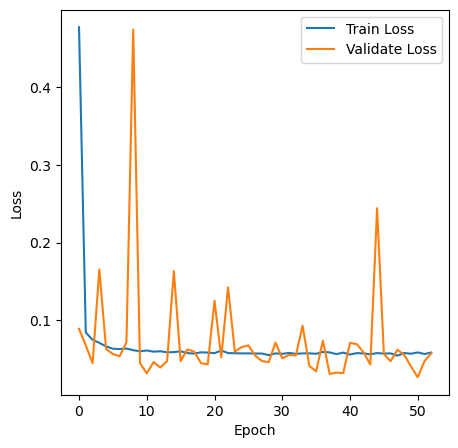

 26%|███████████████████▉                                                       | 53/200 [3:35:59<10:20:06, 253.11s/it]

Epoch:53
Time:3:47:38.296824
Loss:0.05374704376655295
Total:10000  Correct:9827  CleanAccuracy:0.9827


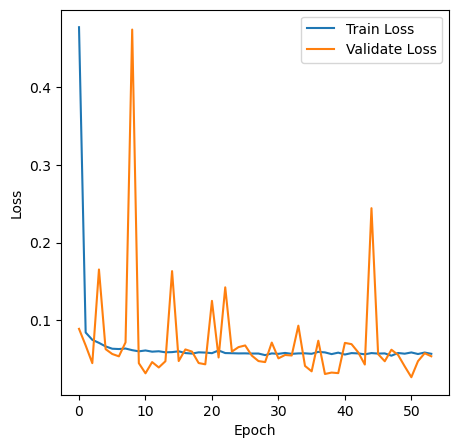

 27%|████████████████████▎                                                      | 54/200 [3:40:09<10:13:13, 252.01s/it]

Epoch:54
Time:3:51:46.469712
Loss:0.45717634692097814
Total:10000  Correct:8629  CleanAccuracy:0.8629


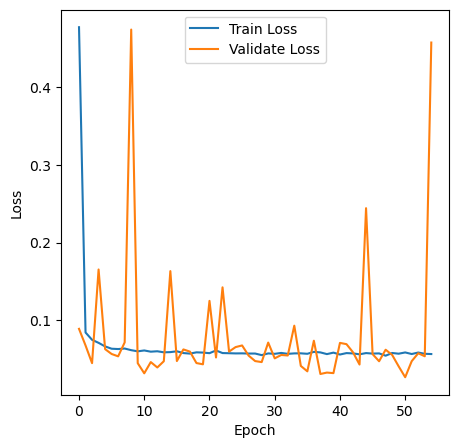

 28%|████████████████████▋                                                      | 55/200 [3:44:17<10:06:26, 250.94s/it]

Epoch:55
Time:3:55:56.952189
Loss:0.06650833357214785
Total:10000  Correct:9827  CleanAccuracy:0.9827


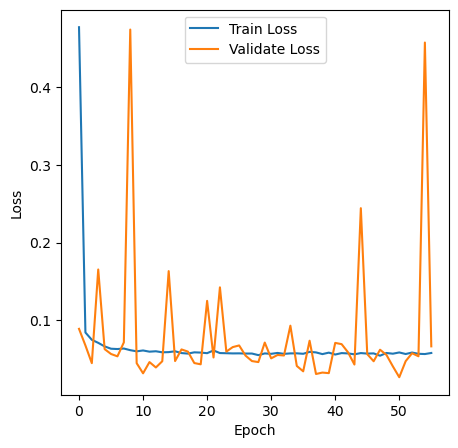

 28%|█████████████████████                                                      | 56/200 [3:48:28<10:01:47, 250.75s/it]

Epoch:56
Time:4:00:06.701583
Loss:0.04045271979540381
Total:10000  Correct:9870  CleanAccuracy:0.9870


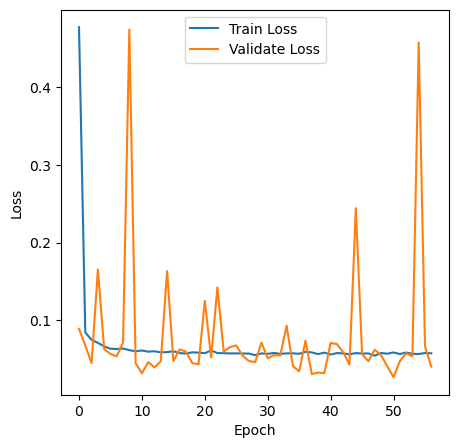

 28%|█████████████████████▋                                                      | 57/200 [3:52:37<9:56:59, 250.49s/it]

Epoch:57
Time:4:04:16.058668
Loss:0.07087926416860198
Total:10000  Correct:9777  CleanAccuracy:0.9777


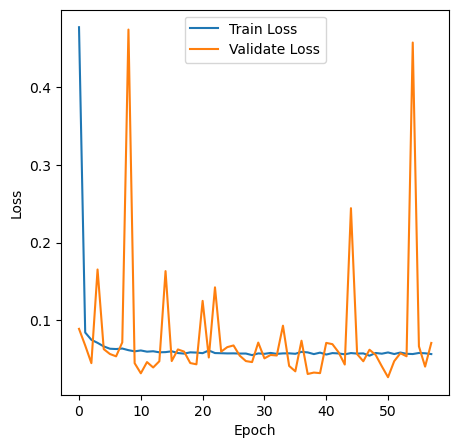

 29%|██████████████████████                                                      | 58/200 [3:56:47<9:52:08, 250.20s/it]

Epoch:58
Time:4:08:26.777172
Loss:0.027947382181425378
Total:10000  Correct:9924  CleanAccuracy:0.9924


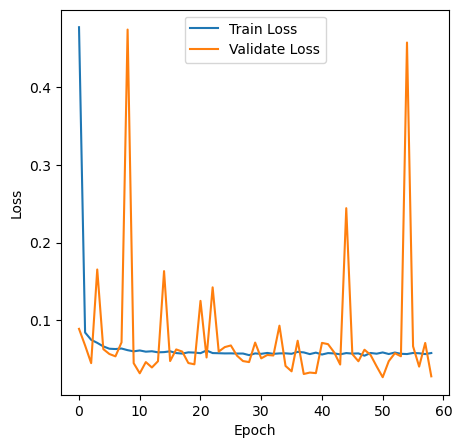

 30%|██████████████████████▍                                                     | 59/200 [4:00:58<9:48:22, 250.38s/it]

Epoch:59
Time:4:12:36.646165
Loss:0.05277156078480943
Total:10000  Correct:9827  CleanAccuracy:0.9827


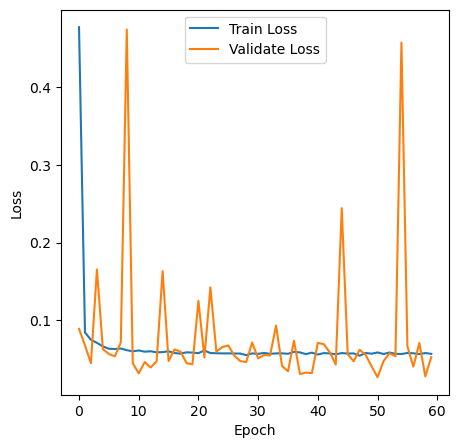

 30%|██████████████████████▊                                                     | 60/200 [4:05:07<9:43:44, 250.18s/it]

Epoch:60
Time:4:16:47.165727
Loss:0.012278388781165637
Total:10000  Correct:9964  CleanAccuracy:0.9964


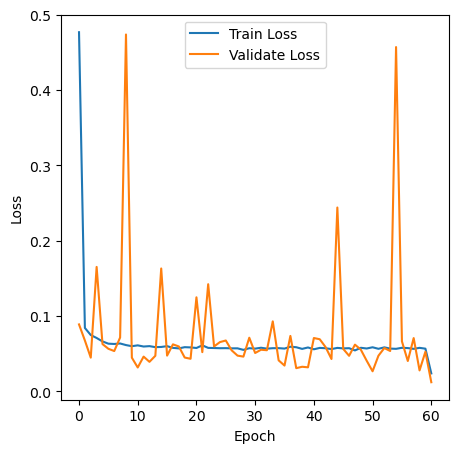

 30%|███████████████████████▏                                                    | 61/200 [4:09:18<9:39:50, 250.29s/it]

Epoch:61
Time:4:20:57.576594
Loss:0.011911387083944664
Total:10000  Correct:9960  CleanAccuracy:0.9960


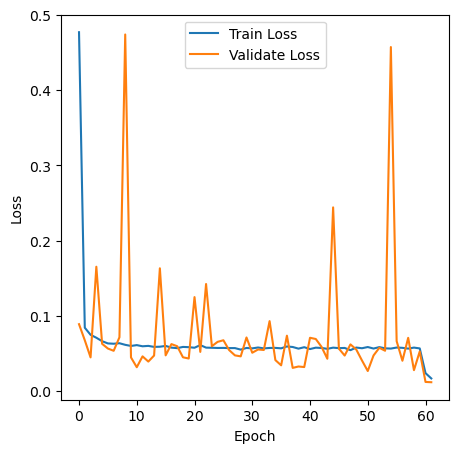

 31%|███████████████████████▌                                                    | 62/200 [4:13:28<9:35:46, 250.34s/it]

Epoch:62
Time:4:25:08.234800
Loss:0.01202504779621304
Total:10000  Correct:9960  CleanAccuracy:0.9960


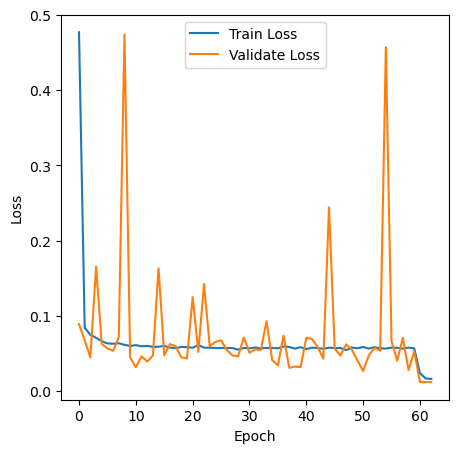

 32%|███████████████████████▉                                                    | 63/200 [4:17:38<9:31:21, 250.23s/it]

Epoch:63
Time:4:29:16.974411
Loss:0.01341457168588202
Total:10000  Correct:9957  CleanAccuracy:0.9957


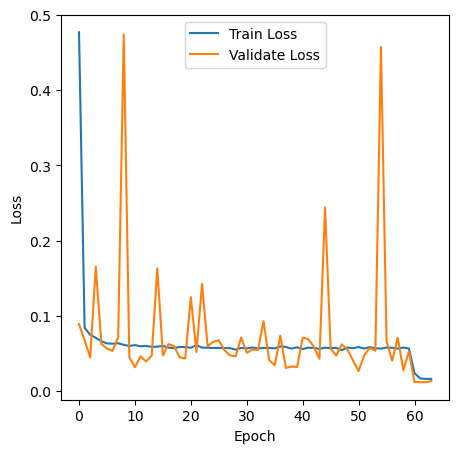

 32%|████████████████████████▎                                                   | 64/200 [4:21:48<9:26:24, 249.88s/it]

Epoch:64
Time:4:33:26.314078
Loss:0.01525979427849136
Total:10000  Correct:9949  CleanAccuracy:0.9949


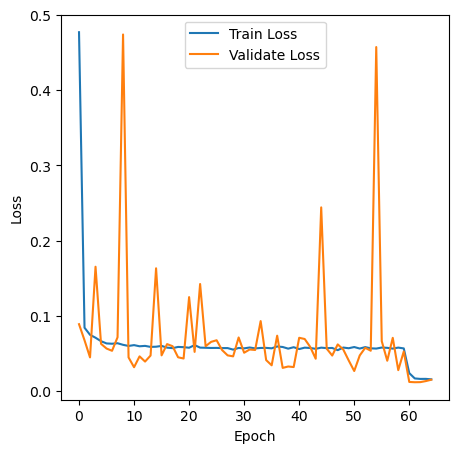

 32%|████████████████████████▋                                                   | 65/200 [4:25:57<9:22:03, 249.80s/it]

Epoch:65
Time:4:37:36.063450
Loss:0.014437019398280482
Total:10000  Correct:9961  CleanAccuracy:0.9961


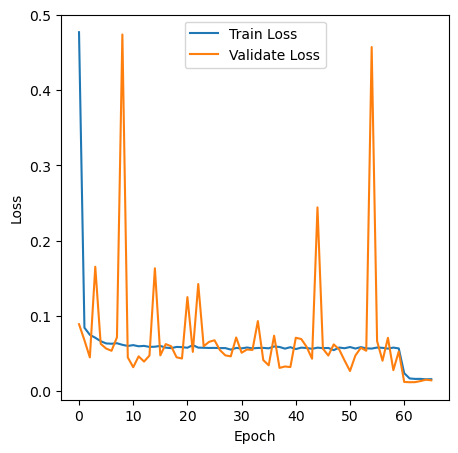

 33%|█████████████████████████                                                   | 66/200 [4:30:06<9:17:26, 249.60s/it]

Epoch:66
Time:4:41:45.872202
Loss:0.011751694349979701
Total:10000  Correct:9965  CleanAccuracy:0.9965


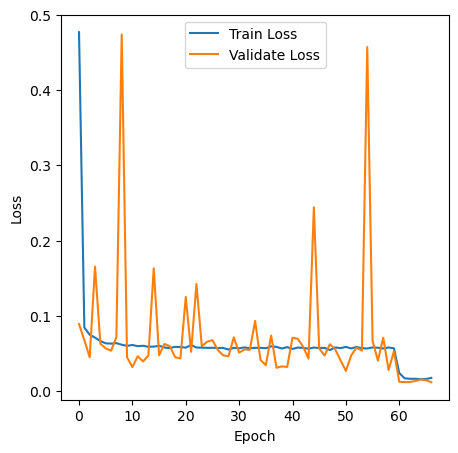

 34%|█████████████████████████▍                                                  | 67/200 [4:34:17<9:13:43, 249.80s/it]

Epoch:67
Time:4:45:55.494114
Loss:0.020720877898142885
Total:10000  Correct:9935  CleanAccuracy:0.9935


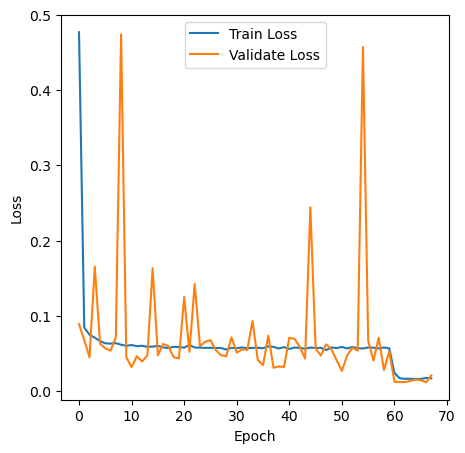

 34%|█████████████████████████▊                                                  | 68/200 [4:38:26<9:09:33, 249.80s/it]

Epoch:68
Time:4:50:04.792463
Loss:0.017954074160066454
Total:10000  Correct:9944  CleanAccuracy:0.9944


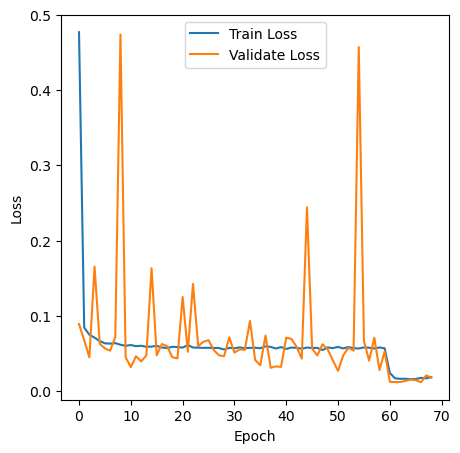

 34%|██████████████████████████▏                                                 | 69/200 [4:42:36<9:05:06, 249.67s/it]

Epoch:69
Time:4:54:15.575944
Loss:0.014782991413619911
Total:10000  Correct:9951  CleanAccuracy:0.9951


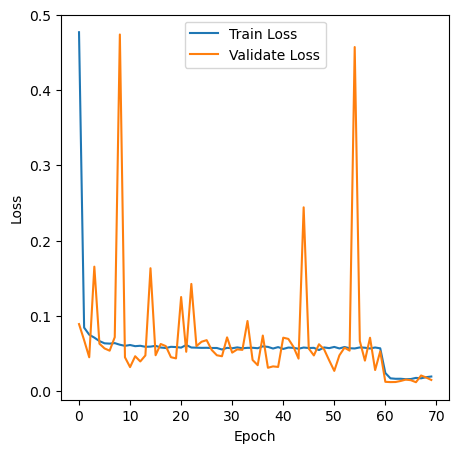

 35%|██████████████████████████▌                                                 | 70/200 [4:46:46<9:01:38, 249.99s/it]

Epoch:70
Time:4:58:26.250783
Loss:0.014692760245318855
Total:10000  Correct:9954  CleanAccuracy:0.9954


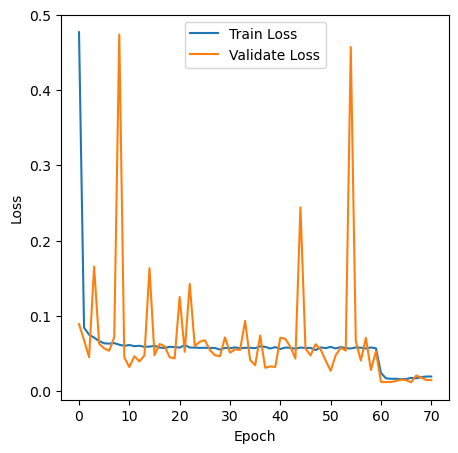

 36%|██████████████████████████▉                                                 | 71/200 [4:50:57<8:57:50, 250.16s/it]

Epoch:71
Time:5:02:36.236285
Loss:0.013845070909330109
Total:10000  Correct:9951  CleanAccuracy:0.9951


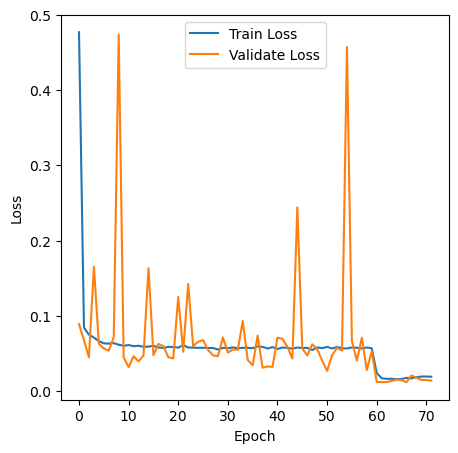

 36%|███████████████████████████▎                                                | 72/200 [4:55:07<8:53:45, 250.20s/it]

Epoch:72
Time:5:06:47.946555
Loss:0.01480823443072235
Total:10000  Correct:9958  CleanAccuracy:0.9958


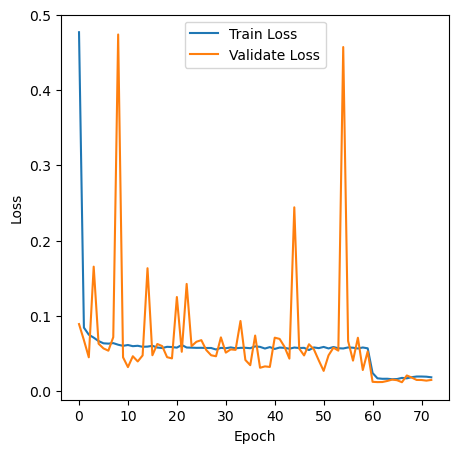

 36%|███████████████████████████▋                                                | 73/200 [4:59:19<8:50:22, 250.57s/it]

Epoch:73
Time:5:11:15.041530
Loss:0.02075151064672683
Total:10000  Correct:9933  CleanAccuracy:0.9933


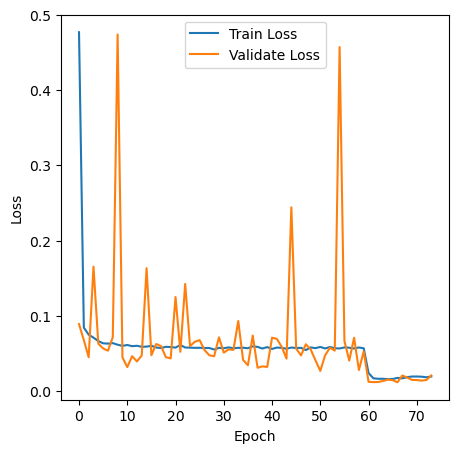

 37%|████████████████████████████                                                | 74/200 [5:03:46<8:56:26, 255.45s/it]

Epoch:74
Time:5:15:34.063677
Loss:0.016425527276016753
Total:10000  Correct:9946  CleanAccuracy:0.9946


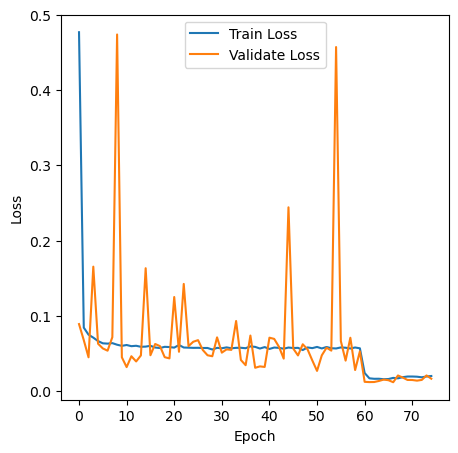

 38%|████████████████████████████▌                                               | 75/200 [5:08:05<8:54:35, 256.60s/it]

Epoch:75
Time:5:20:11.083784
Loss:0.01709144688828792
Total:10000  Correct:9949  CleanAccuracy:0.9949


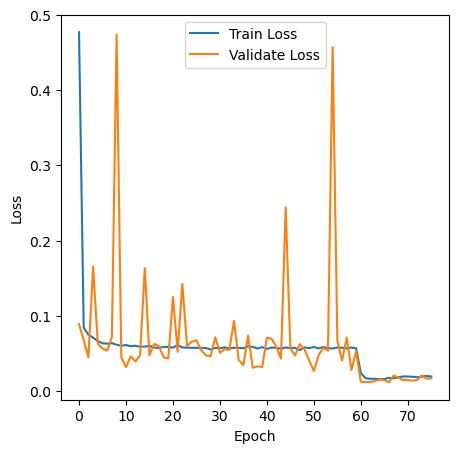

 38%|████████████████████████████▉                                               | 76/200 [5:12:41<9:02:29, 262.49s/it]

Epoch:76
Time:5:24:46.243522
Loss:0.027554603894025434
Total:10000  Correct:9916  CleanAccuracy:0.9916


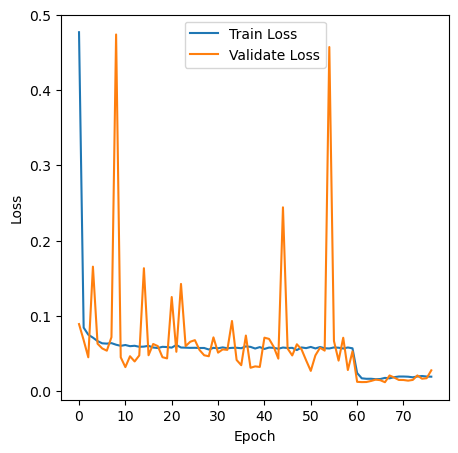

 38%|█████████████████████████████▎                                              | 77/200 [5:17:17<9:06:18, 266.49s/it]

Epoch:77
Time:5:29:14.688943
Loss:0.019078811073914532
Total:10000  Correct:9943  CleanAccuracy:0.9943


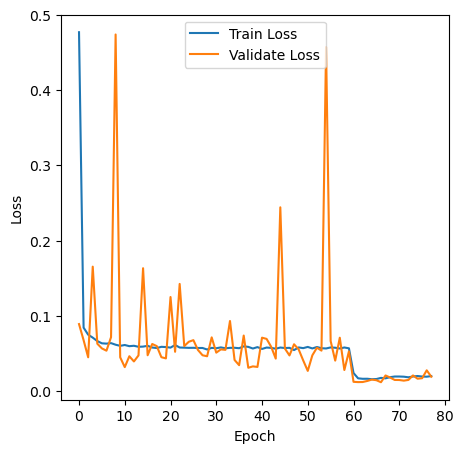

 39%|█████████████████████████████▋                                              | 78/200 [5:21:46<9:03:13, 267.16s/it]

Epoch:78
Time:5:33:40.400877
Loss:0.015833515929859338
Total:10000  Correct:9952  CleanAccuracy:0.9952


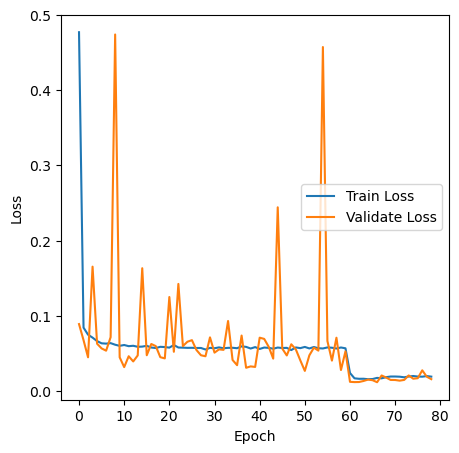

 40%|██████████████████████████████                                              | 79/200 [5:26:11<8:57:46, 266.66s/it]

Epoch:79
Time:5:37:50.900986
Loss:0.018742004415755287
Total:10000  Correct:9951  CleanAccuracy:0.9951


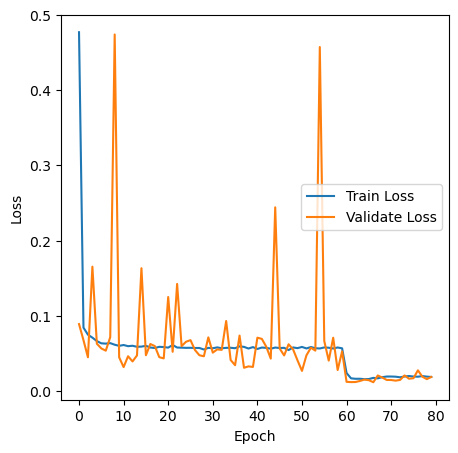

 40%|██████████████████████████████▍                                             | 80/200 [5:30:21<8:43:31, 261.76s/it]

Epoch:80
Time:5:42:01.558760
Loss:0.01687363777238989
Total:10000  Correct:9952  CleanAccuracy:0.9952


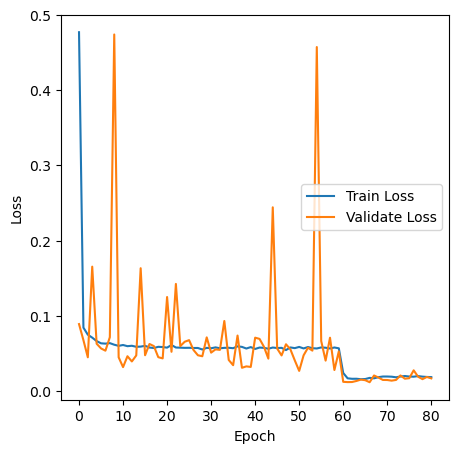

 40%|██████████████████████████████▊                                             | 81/200 [5:34:32<8:32:43, 258.52s/it]

Epoch:81
Time:5:46:12.300216
Loss:0.0177835956291733
Total:10000  Correct:9936  CleanAccuracy:0.9936


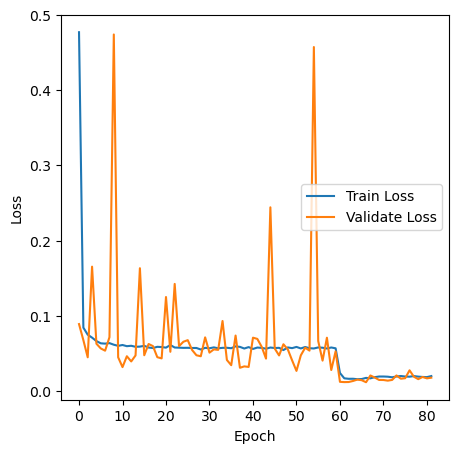

 41%|███████████████████████████████▏                                            | 82/200 [5:38:42<8:23:26, 255.99s/it]

Epoch:82
Time:5:50:20.632625
Loss:0.019516389856796365
Total:10000  Correct:9947  CleanAccuracy:0.9947


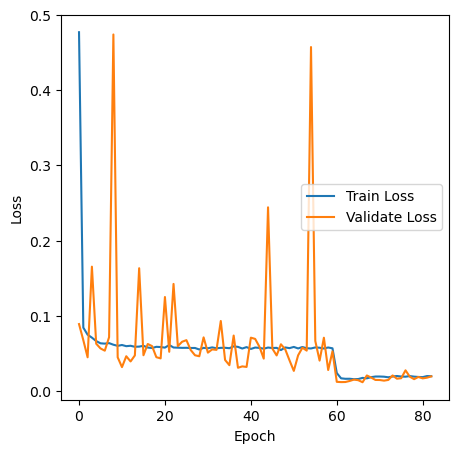

 42%|███████████████████████████████▌                                            | 83/200 [5:42:51<8:15:02, 253.87s/it]

Epoch:83
Time:5:54:31.119608
Loss:0.01743880167589359
Total:10000  Correct:9947  CleanAccuracy:0.9947


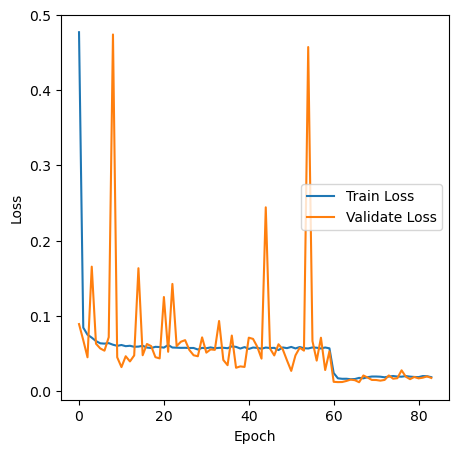

 42%|███████████████████████████████▉                                            | 84/200 [5:47:01<8:08:35, 252.72s/it]

Epoch:84
Time:5:58:40.826993
Loss:0.02033975137454925
Total:10000  Correct:9943  CleanAccuracy:0.9943


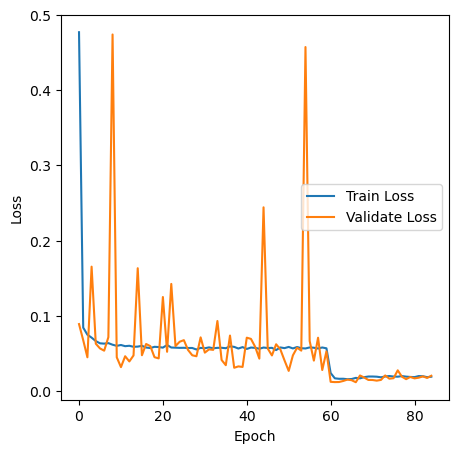

 42%|████████████████████████████████▎                                           | 85/200 [5:51:12<8:02:56, 251.97s/it]

Epoch:85
Time:6:02:50.747353
Loss:0.018922757762580955
Total:10000  Correct:9939  CleanAccuracy:0.9939


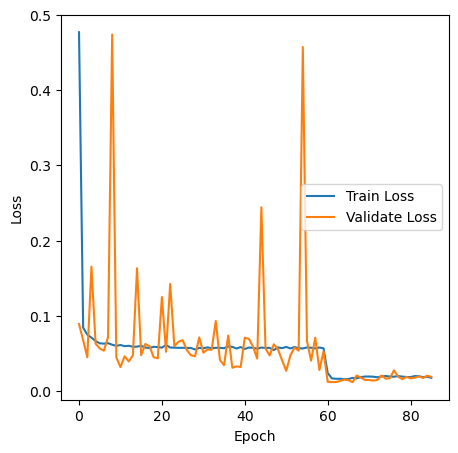

 43%|████████████████████████████████▋                                           | 86/200 [5:55:22<7:57:34, 251.35s/it]

Epoch:86
Time:6:07:00.265181
Loss:0.017856048560290695
Total:10000  Correct:9956  CleanAccuracy:0.9956


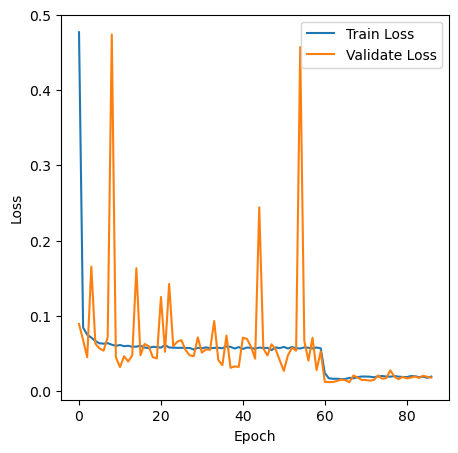

 44%|█████████████████████████████████                                           | 87/200 [5:59:31<7:52:19, 250.80s/it]

Epoch:87
Time:6:11:09.036655
Loss:0.01921441203818996
Total:10000  Correct:9951  CleanAccuracy:0.9951


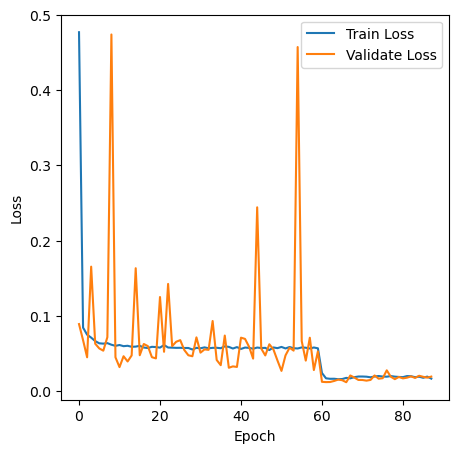

 44%|█████████████████████████████████▍                                          | 88/200 [6:03:40<7:46:59, 250.17s/it]

Epoch:88
Time:6:15:18.787880
Loss:0.01683960915520823
Total:10000  Correct:9950  CleanAccuracy:0.9950


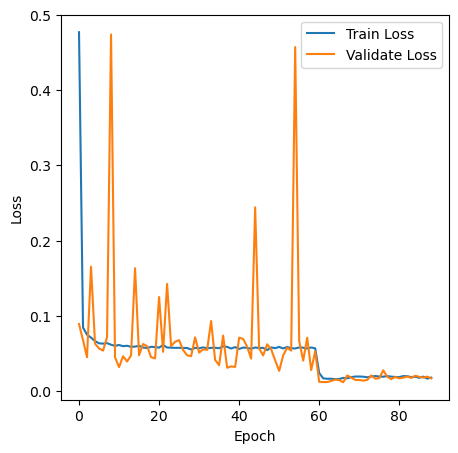

 44%|█████████████████████████████████▊                                          | 89/200 [6:07:50<7:42:42, 250.11s/it]

Epoch:89
Time:6:19:29.083807
Loss:0.01621736374909814
Total:10000  Correct:9944  CleanAccuracy:0.9944


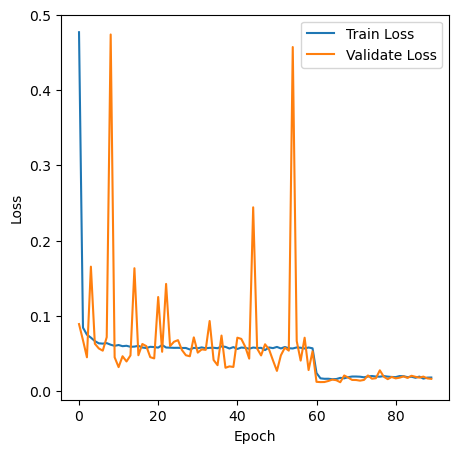

 45%|██████████████████████████████████▏                                         | 90/200 [6:12:00<7:38:26, 250.06s/it]

Epoch:90
Time:6:23:38.701941
Loss:0.014842991210306777
Total:10000  Correct:9951  CleanAccuracy:0.9951


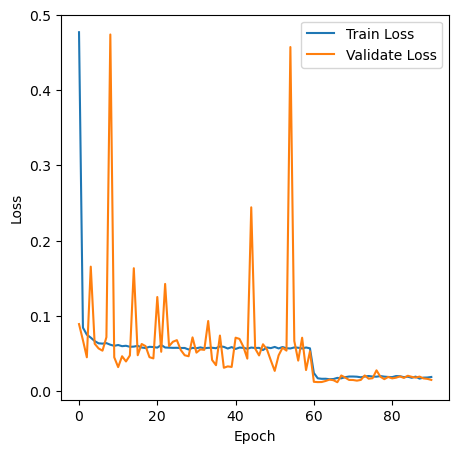

 46%|██████████████████████████████████▌                                         | 91/200 [6:16:08<7:33:28, 249.62s/it]

Epoch:91
Time:6:27:47.635252
Loss:0.020925130657911205
Total:10000  Correct:9943  CleanAccuracy:0.9943


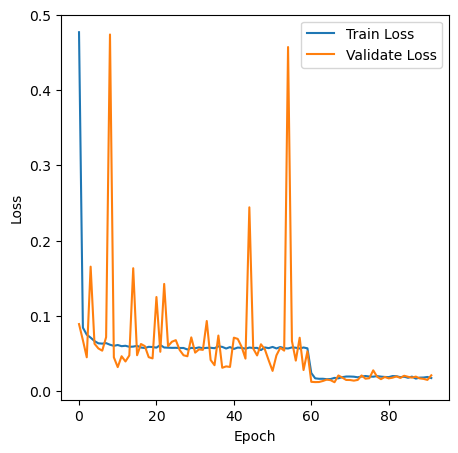

 46%|██████████████████████████████████▉                                         | 92/200 [6:20:18<7:29:18, 249.62s/it]

Epoch:92
Time:6:31:56.561196
Loss:0.02234983235252084
Total:10000  Correct:9939  CleanAccuracy:0.9939


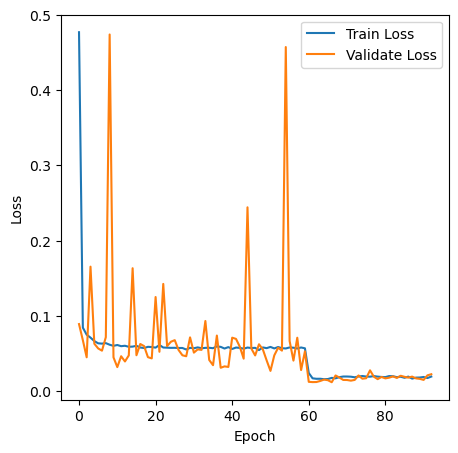

 46%|███████████████████████████████████▎                                        | 93/200 [6:24:27<7:24:57, 249.51s/it]

Epoch:93
Time:6:36:06.253941
Loss:0.01753460423629984
Total:10000  Correct:9946  CleanAccuracy:0.9946


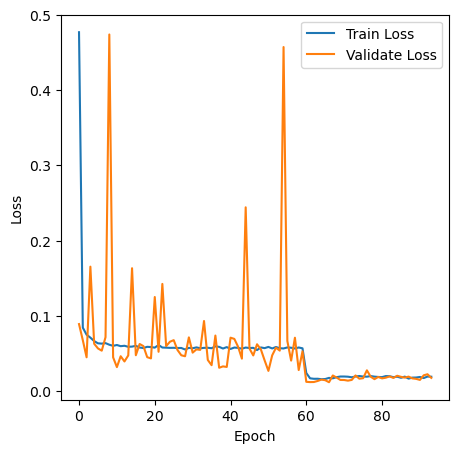

 47%|███████████████████████████████████▋                                        | 94/200 [6:28:37<7:20:57, 249.60s/it]

Epoch:94
Time:6:40:11.206432
Loss:0.017025697700189836
Total:10000  Correct:9951  CleanAccuracy:0.9951


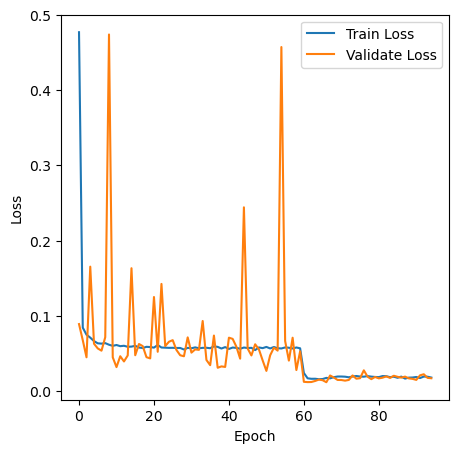

 48%|████████████████████████████████████                                        | 95/200 [6:32:41<7:14:07, 248.07s/it]

Epoch:95
Time:6:44:15.897517
Loss:0.020325230213608176
Total:10000  Correct:9939  CleanAccuracy:0.9939


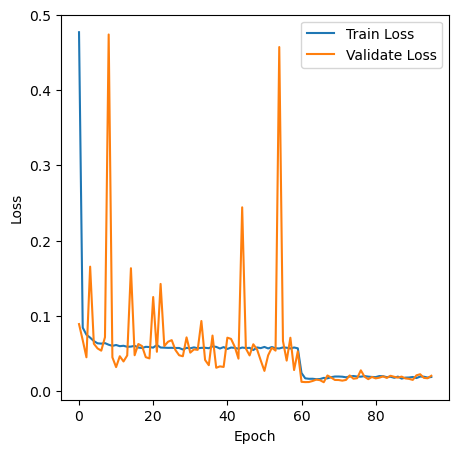

 48%|████████████████████████████████████▍                                       | 96/200 [6:36:46<7:08:21, 247.13s/it]

Epoch:96
Time:6:48:20.718467
Loss:0.019664651361671975
Total:10000  Correct:9942  CleanAccuracy:0.9942


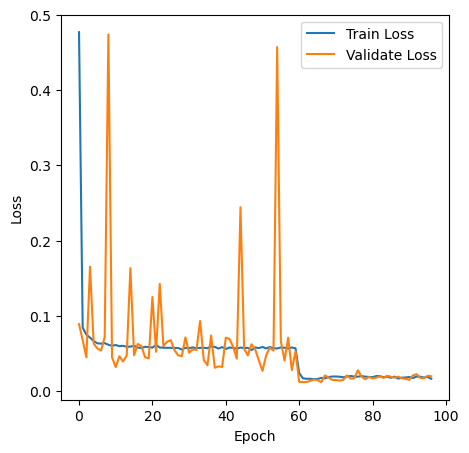

 48%|████████████████████████████████████▊                                       | 97/200 [6:40:50<7:02:35, 246.17s/it]

Epoch:97
Time:6:52:24.133486
Loss:0.02451022840954866
Total:10000  Correct:9933  CleanAccuracy:0.9933


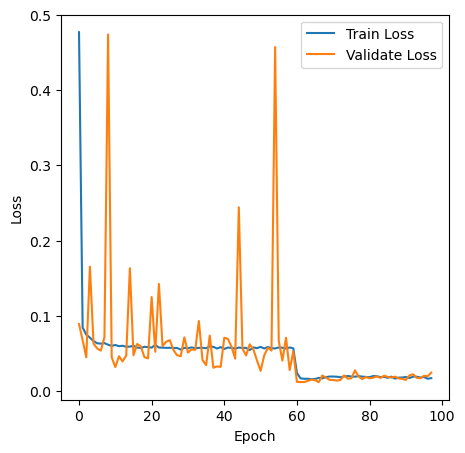

 49%|█████████████████████████████████████▏                                      | 98/200 [6:44:55<6:57:30, 245.59s/it]

Epoch:98
Time:6:56:28.657244
Loss:0.027108625116268582
Total:10000  Correct:9913  CleanAccuracy:0.9913


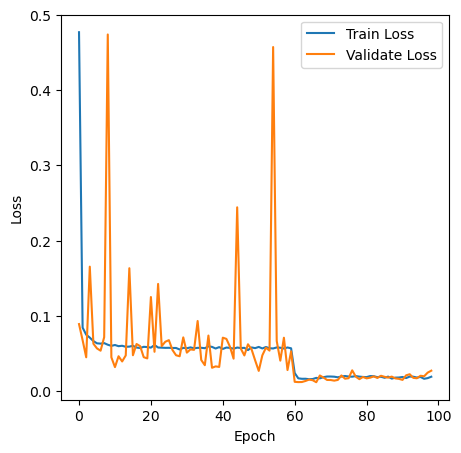

 50%|█████████████████████████████████████▌                                      | 99/200 [6:48:59<6:52:58, 245.34s/it]

Epoch:99
Time:7:00:32.317126
Loss:0.013283404406623546
Total:10000  Correct:9962  CleanAccuracy:0.9962


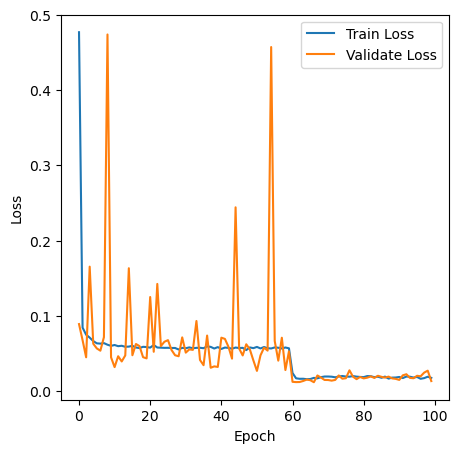

 50%|█████████████████████████████████████▌                                     | 100/200 [6:53:02<6:47:26, 244.47s/it]

Epoch:100
Time:7:04:35.437596
Loss:0.016751620730127807
Total:10000  Correct:9947  CleanAccuracy:0.9947


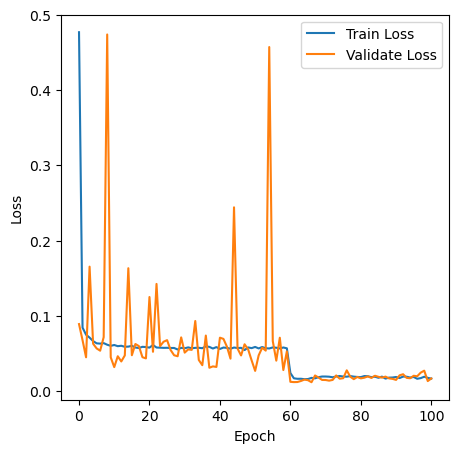

 50%|█████████████████████████████████████▉                                     | 101/200 [6:57:06<6:43:11, 244.36s/it]

Epoch:101
Time:7:08:41.570724
Loss:0.02092057314162818
Total:10000  Correct:9940  CleanAccuracy:0.9940


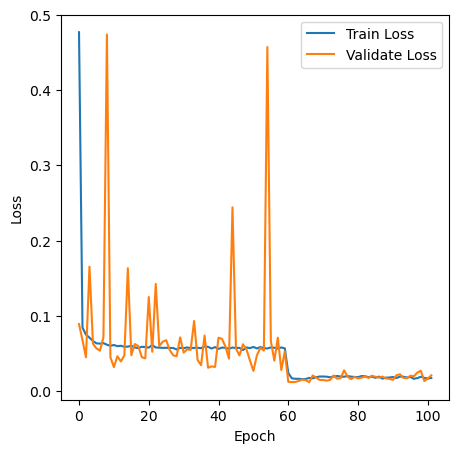

 51%|██████████████████████████████████████▎                                    | 102/200 [7:01:12<6:39:59, 244.89s/it]

Epoch:102
Time:7:12:48.690870
Loss:0.01814290199550791
Total:10000  Correct:9943  CleanAccuracy:0.9943


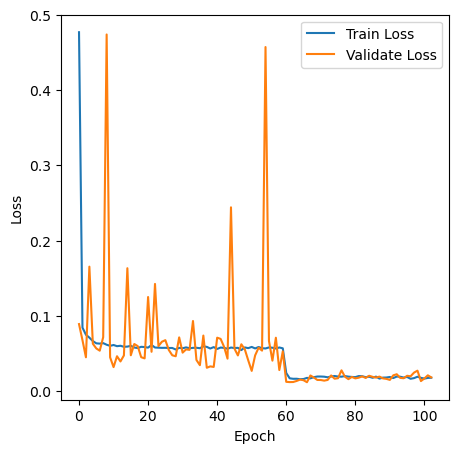

 52%|██████████████████████████████████████▋                                    | 103/200 [7:05:19<6:36:55, 245.52s/it]

Epoch:103
Time:7:16:58.658887
Loss:0.01710317914557164
Total:10000  Correct:9950  CleanAccuracy:0.9950


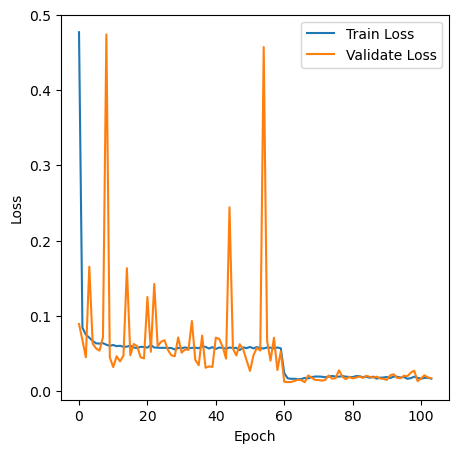

 52%|███████████████████████████████████████                                    | 104/200 [7:09:29<6:35:02, 246.90s/it]

Epoch:104
Time:7:21:10.594401
Loss:0.01592036043502057
Total:10000  Correct:9955  CleanAccuracy:0.9955


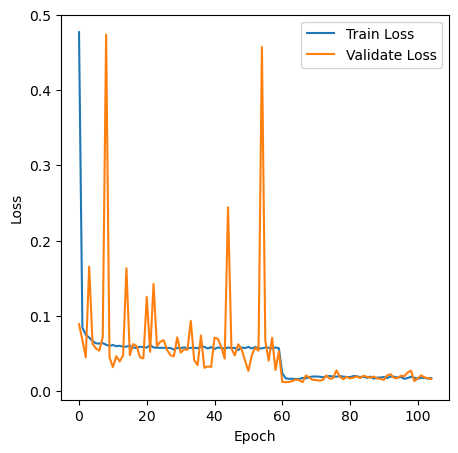

 52%|███████████████████████████████████████▍                                   | 105/200 [7:13:41<6:33:23, 248.46s/it]

Epoch:105
Time:7:25:47.061762
Loss:0.018638126487388443
Total:10000  Correct:9947  CleanAccuracy:0.9947


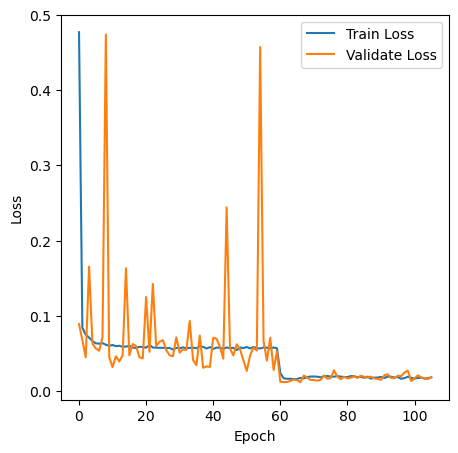

 53%|███████████████████████████████████████▊                                   | 106/200 [7:18:18<6:42:20, 256.81s/it]

Epoch:106
Time:7:29:51.337878
Loss:0.02668024575897156
Total:10000  Correct:9925  CleanAccuracy:0.9925


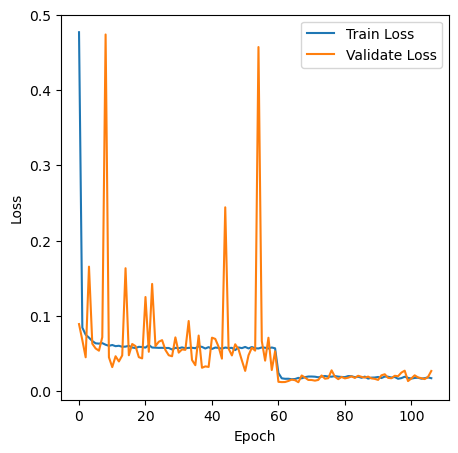

 54%|████████████████████████████████████████▏                                  | 107/200 [7:22:22<6:32:09, 253.00s/it]

Epoch:107
Time:7:33:57.042838
Loss:0.016896529343929857
Total:10000  Correct:9950  CleanAccuracy:0.9950


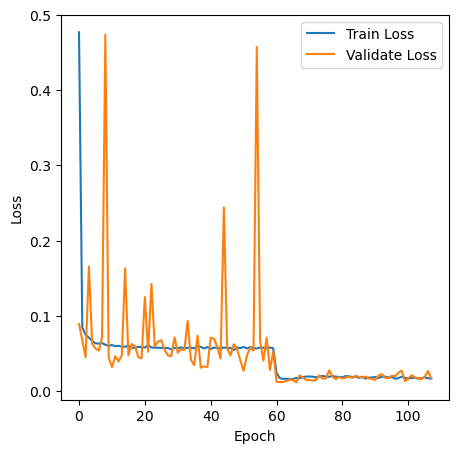

 54%|████████████████████████████████████████▌                                  | 108/200 [7:26:27<6:24:16, 250.62s/it]

Epoch:108
Time:7:38:00.736162
Loss:0.018577586027076497
Total:10000  Correct:9945  CleanAccuracy:0.9945


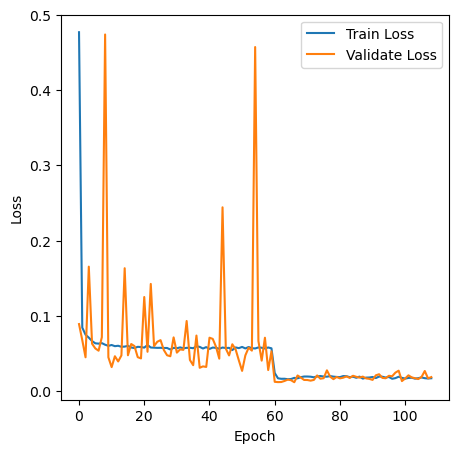

 55%|████████████████████████████████████████▉                                  | 109/200 [7:30:31<6:17:11, 248.70s/it]

Epoch:109
Time:7:42:03.734967
Loss:0.02155729617074373
Total:10000  Correct:9936  CleanAccuracy:0.9936


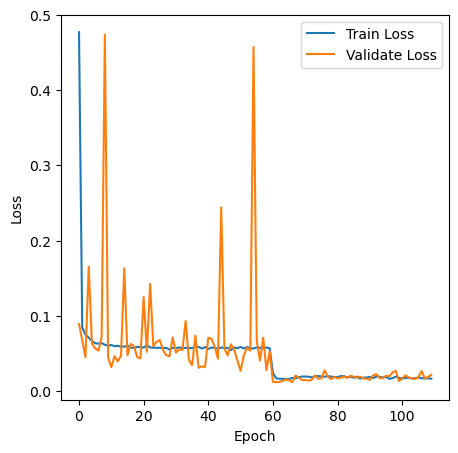

 55%|█████████████████████████████████████████▎                                 | 110/200 [7:34:33<6:10:11, 246.80s/it]

Epoch:110
Time:7:46:05.846359
Loss:0.01778056874646978
Total:10000  Correct:9940  CleanAccuracy:0.9940


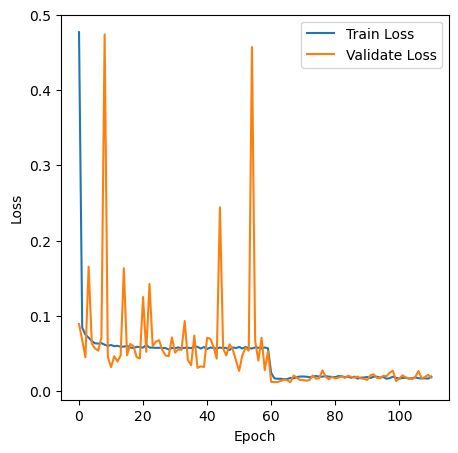

 56%|█████████████████████████████████████████▋                                 | 111/200 [7:38:37<6:04:29, 245.73s/it]

Epoch:111
Time:7:50:10.461276
Loss:0.018355669194223215
Total:10000  Correct:9945  CleanAccuracy:0.9945


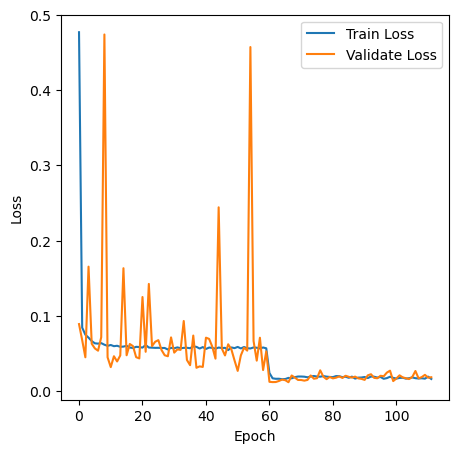

 56%|██████████████████████████████████████████                                 | 112/200 [7:42:41<5:59:54, 245.40s/it]

Epoch:112
Time:7:54:14.955061
Loss:0.017526899747563135
Total:10000  Correct:9944  CleanAccuracy:0.9944


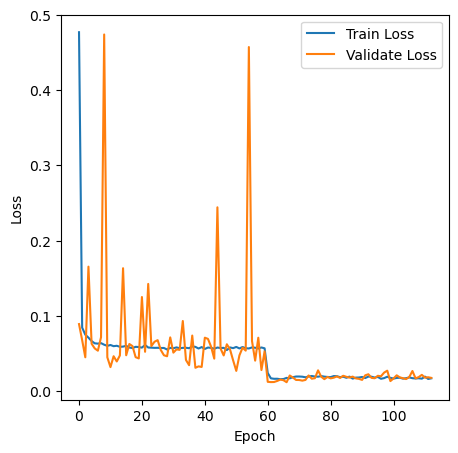

 56%|██████████████████████████████████████████▎                                | 113/200 [7:46:45<5:55:18, 245.04s/it]

Epoch:113
Time:7:58:19.643991
Loss:0.03033930181968993
Total:10000  Correct:9918  CleanAccuracy:0.9918


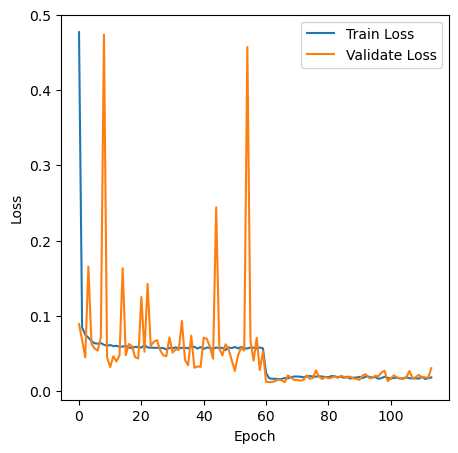

 57%|██████████████████████████████████████████▋                                | 114/200 [7:50:50<5:51:04, 244.93s/it]

Epoch:114
Time:8:02:23.603567
Loss:0.024166502480186113
Total:10000  Correct:9932  CleanAccuracy:0.9932


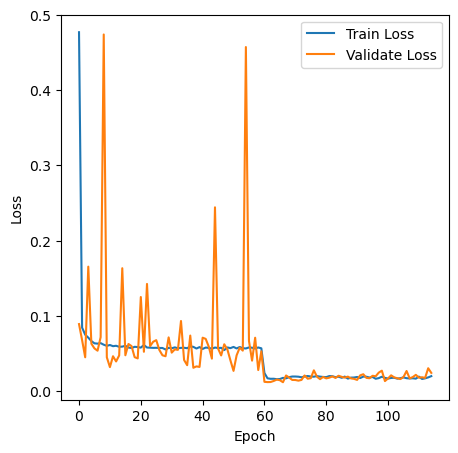

 57%|███████████████████████████████████████████▏                               | 115/200 [7:54:54<5:46:37, 244.67s/it]

Epoch:115
Time:8:06:35.676544
Loss:0.01631838811848598
Total:10000  Correct:9957  CleanAccuracy:0.9957


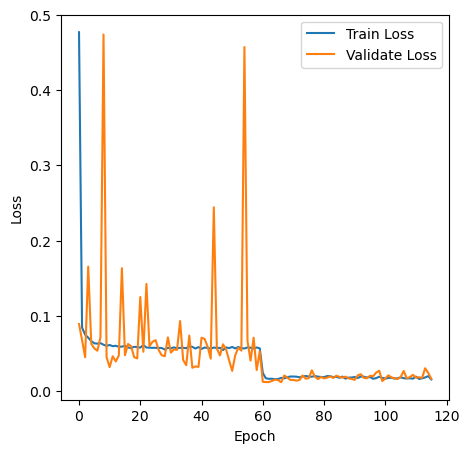

 58%|███████████████████████████████████████████▌                               | 116/200 [7:59:06<5:45:35, 246.85s/it]

Epoch:116
Time:8:10:40.973431
Loss:0.017495832355122434
Total:10000  Correct:9944  CleanAccuracy:0.9944


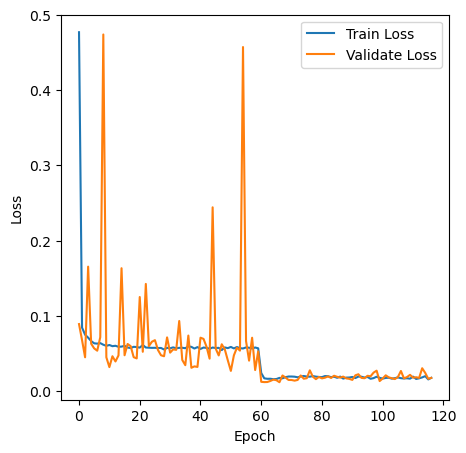

 58%|███████████████████████████████████████████▉                               | 117/200 [8:03:12<5:40:57, 246.48s/it]

Epoch:117
Time:8:14:45.544059
Loss:0.014719448953635616
Total:10000  Correct:9960  CleanAccuracy:0.9960


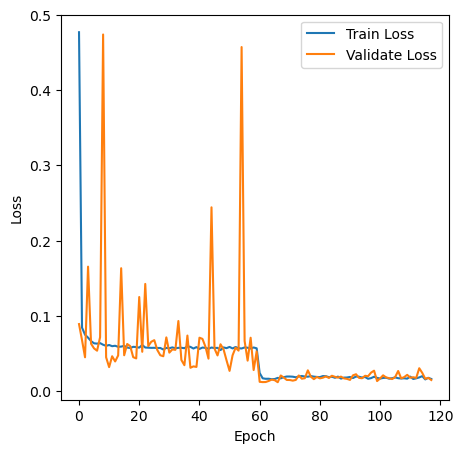

 59%|████████████████████████████████████████████▎                              | 118/200 [8:07:16<5:36:04, 245.91s/it]

Epoch:118
Time:8:18:49.827665
Loss:0.02261364464101325
Total:10000  Correct:9936  CleanAccuracy:0.9936


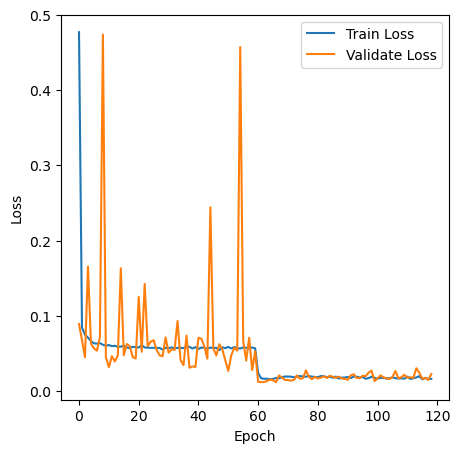

 60%|████████████████████████████████████████████▋                              | 119/200 [8:11:21<5:31:20, 245.44s/it]

Epoch:119
Time:8:22:54.380552
Loss:0.01846461725616887
Total:10000  Correct:9938  CleanAccuracy:0.9938


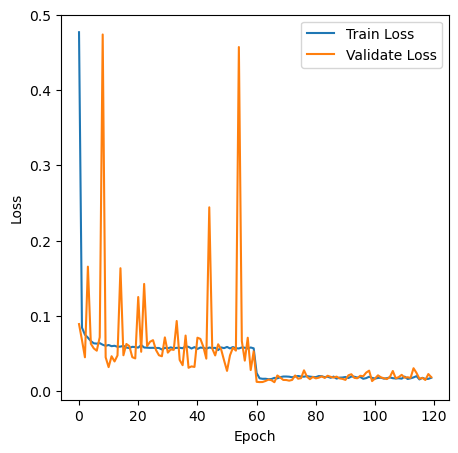

 60%|█████████████████████████████████████████████                              | 120/200 [8:15:25<5:26:49, 245.12s/it]

Epoch:120
Time:8:27:00.250402
Loss:0.010318080638386547
Total:10000  Correct:9965  CleanAccuracy:0.9965


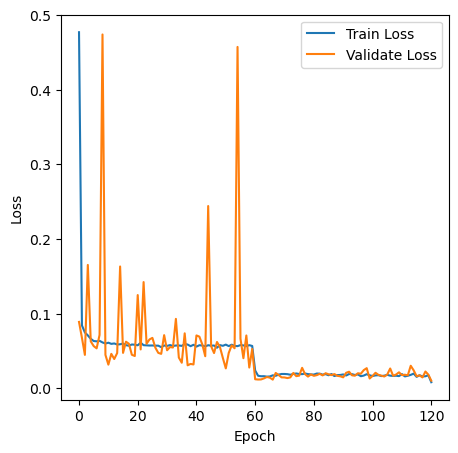

 60%|█████████████████████████████████████████████▍                             | 121/200 [8:19:31<5:23:01, 245.33s/it]

Epoch:121
Time:8:31:05.135855
Loss:0.010210498143880132
Total:10000  Correct:9970  CleanAccuracy:0.9970


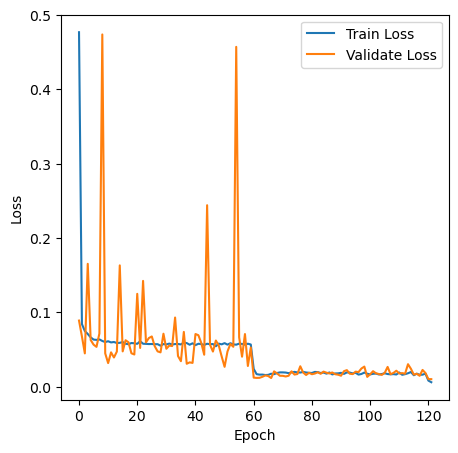

 61%|█████████████████████████████████████████████▊                             | 122/200 [8:23:36<5:18:58, 245.37s/it]

Epoch:122
Time:8:35:11.037961
Loss:0.009726569025733392
Total:10000  Correct:9968  CleanAccuracy:0.9968


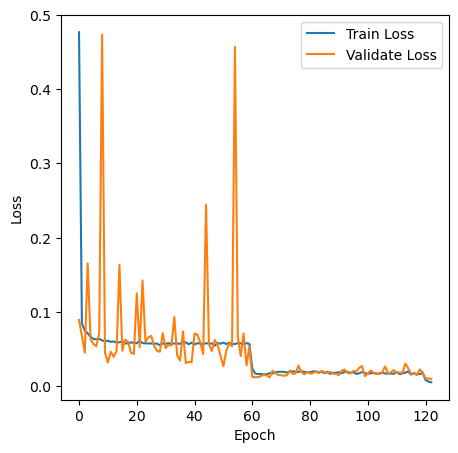

 62%|██████████████████████████████████████████████▏                            | 123/200 [8:27:42<5:15:00, 245.46s/it]

Epoch:123
Time:8:39:16.534380
Loss:0.009787099351031564
Total:10000  Correct:9969  CleanAccuracy:0.9969


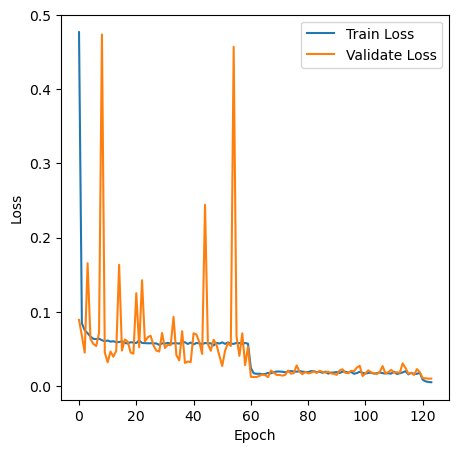

 62%|██████████████████████████████████████████████▌                            | 124/200 [8:31:46<5:10:24, 245.06s/it]

Epoch:124
Time:8:43:20.584854
Loss:0.009374891577482659
Total:10000  Correct:9969  CleanAccuracy:0.9969


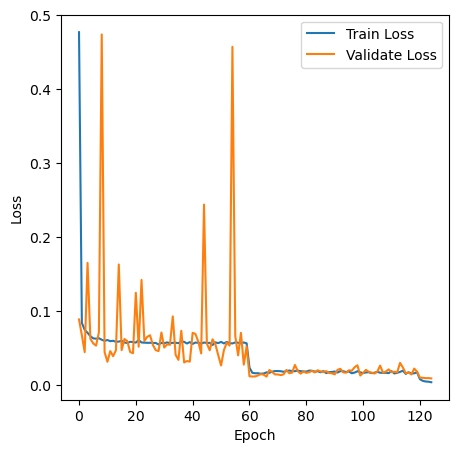

 62%|██████████████████████████████████████████████▉                            | 125/200 [8:35:51<5:06:18, 245.05s/it]

Epoch:125
Time:8:47:25.485258
Loss:0.009268740587142525
Total:10000  Correct:9970  CleanAccuracy:0.9970


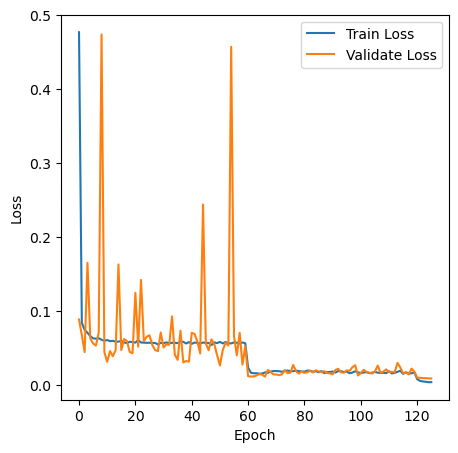

 63%|███████████████████████████████████████████████▎                           | 126/200 [8:39:56<5:02:09, 245.00s/it]

Epoch:126
Time:8:51:30.075410
Loss:0.009695100168639514
Total:10000  Correct:9965  CleanAccuracy:0.9965


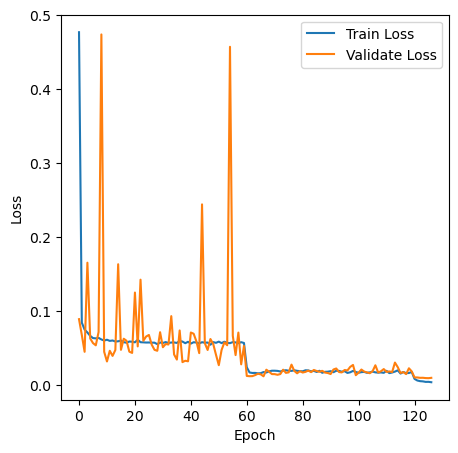

 64%|███████████████████████████████████████████████▋                           | 127/200 [8:44:01<4:58:04, 244.99s/it]

Epoch:127
Time:8:55:34.529248
Loss:0.010308727438017851
Total:10000  Correct:9970  CleanAccuracy:0.9970


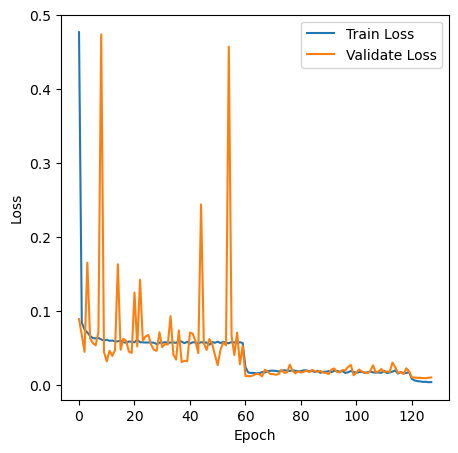

 64%|████████████████████████████████████████████████                           | 128/200 [8:48:04<4:53:20, 244.45s/it]

Epoch:128
Time:8:59:38.030057
Loss:0.01008713764937062
Total:10000  Correct:9967  CleanAccuracy:0.9967


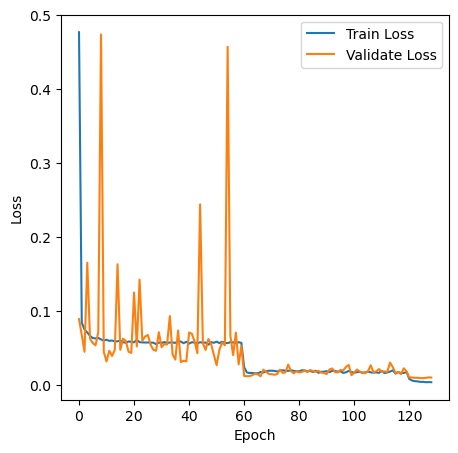

 64%|████████████████████████████████████████████████▍                          | 129/200 [8:52:09<4:49:17, 244.47s/it]

Epoch:129
Time:9:03:42.052218
Loss:0.010794297023415982
Total:10000  Correct:9965  CleanAccuracy:0.9965


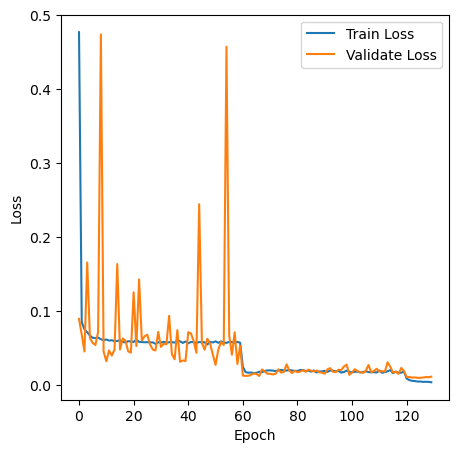

 65%|████████████████████████████████████████████████▊                          | 130/200 [8:56:13<4:45:11, 244.45s/it]

Epoch:130
Time:9:07:47.925621
Loss:0.010345707040134305
Total:10000  Correct:9966  CleanAccuracy:0.9966


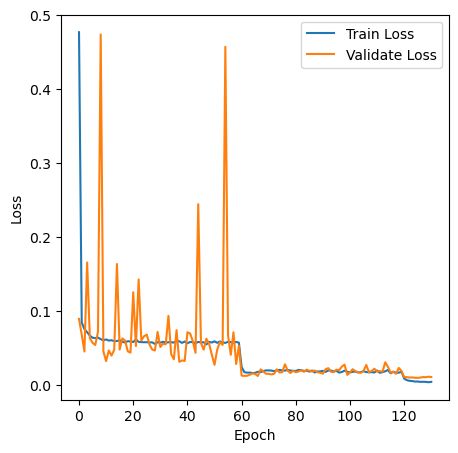

 66%|█████████████████████████████████████████████████▏                         | 131/200 [9:00:19<4:41:35, 244.86s/it]

Epoch:131
Time:9:11:52.736722
Loss:0.009906761182364993
Total:10000  Correct:9966  CleanAccuracy:0.9966


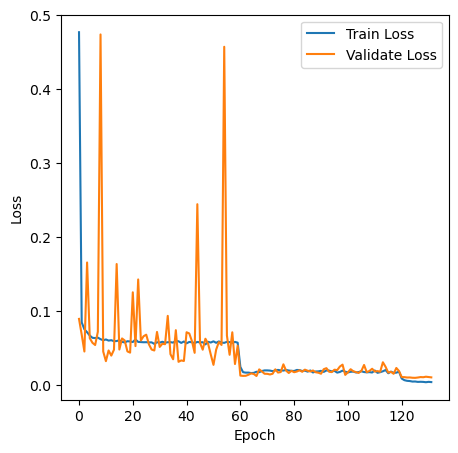

 66%|█████████████████████████████████████████████████▌                         | 132/200 [9:04:24<4:37:30, 244.86s/it]

Epoch:132
Time:9:15:57.190305
Loss:0.010747915357738114
Total:10000  Correct:9971  CleanAccuracy:0.9971


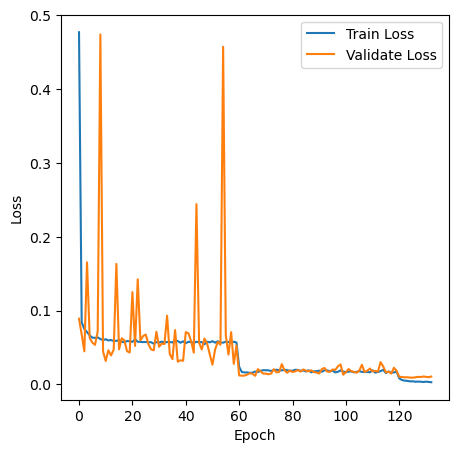

 66%|█████████████████████████████████████████████████▉                         | 133/200 [9:08:28<4:33:19, 244.77s/it]

Epoch:133
Time:9:20:04.150042
Loss:0.011595420248805733
Total:10000  Correct:9970  CleanAccuracy:0.9970


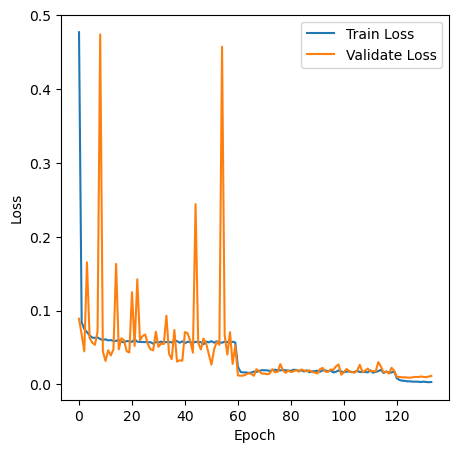

 67%|██████████████████████████████████████████████████▎                        | 134/200 [9:12:35<4:29:49, 245.29s/it]

Epoch:134
Time:9:24:10.177981
Loss:0.011185883093229569
Total:10000  Correct:9968  CleanAccuracy:0.9968


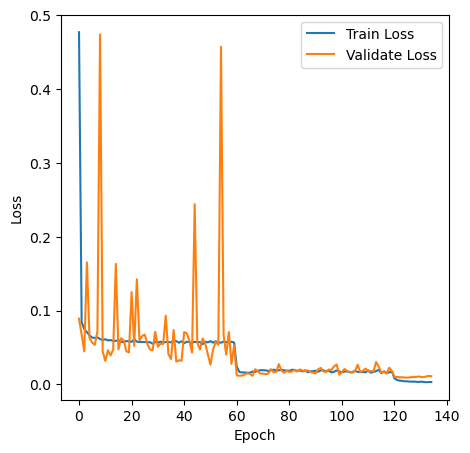

 68%|██████████████████████████████████████████████████▋                        | 135/200 [9:16:41<4:26:00, 245.55s/it]

Epoch:135
Time:9:28:16.209038
Loss:0.01024063429854715
Total:10000  Correct:9969  CleanAccuracy:0.9969


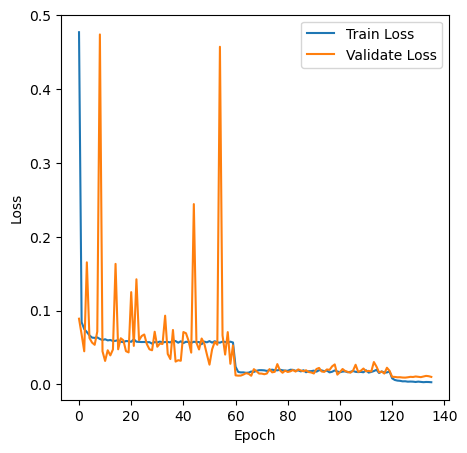

 68%|███████████████████████████████████████████████████                        | 136/200 [9:20:45<4:21:31, 245.18s/it]

Epoch:136
Time:9:32:22.979965
Loss:0.010423724382993774
Total:10000  Correct:9968  CleanAccuracy:0.9968


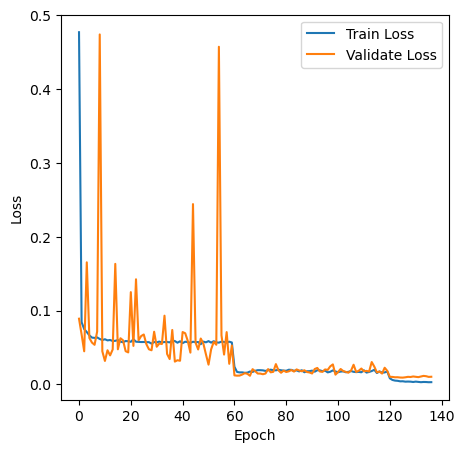

 68%|███████████████████████████████████████████████████▍                       | 137/200 [9:24:54<4:18:28, 246.17s/it]

Epoch:137
Time:9:36:28.781785
Loss:0.011447187563324104
Total:10000  Correct:9970  CleanAccuracy:0.9970


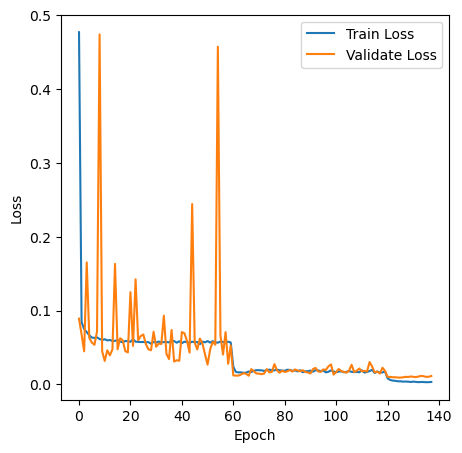

 69%|███████████████████████████████████████████████████▋                       | 138/200 [9:28:59<4:14:14, 246.04s/it]

Epoch:138
Time:9:40:33.869978
Loss:0.011597861310455222
Total:10000  Correct:9968  CleanAccuracy:0.9968


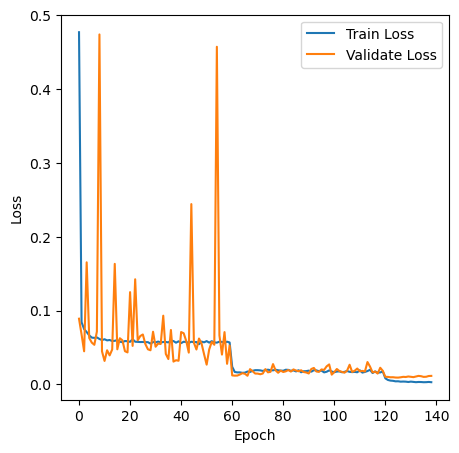

 70%|████████████████████████████████████████████████████                       | 139/200 [9:33:05<4:09:52, 245.78s/it]

Epoch:139
Time:9:44:38.906278
Loss:0.011086595368931612
Total:10000  Correct:9968  CleanAccuracy:0.9968


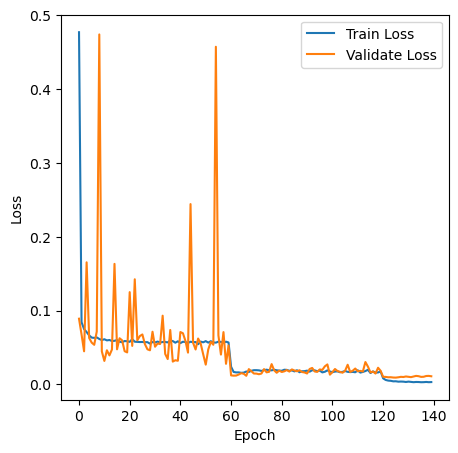

 70%|████████████████████████████████████████████████████▌                      | 140/200 [9:37:09<4:05:25, 245.43s/it]

Epoch:140
Time:9:48:42.743074
Loss:0.01130991037239502
Total:10000  Correct:9968  CleanAccuracy:0.9968


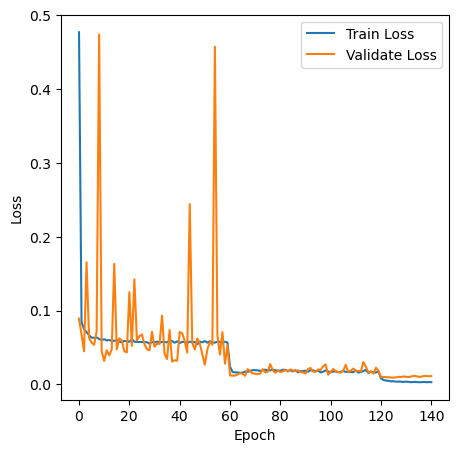

 70%|████████████████████████████████████████████████████▉                      | 141/200 [9:41:13<4:00:55, 245.01s/it]

Epoch:141
Time:9:52:48.043955
Loss:0.011561502913792675
Total:10000  Correct:9971  CleanAccuracy:0.9971


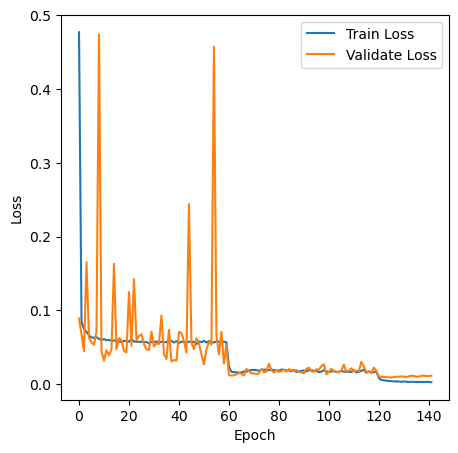

 71%|█████████████████████████████████████████████████████▎                     | 142/200 [9:45:19<3:56:58, 245.14s/it]

Epoch:142
Time:9:56:52.379017
Loss:0.012177835496814964
Total:10000  Correct:9972  CleanAccuracy:0.9972


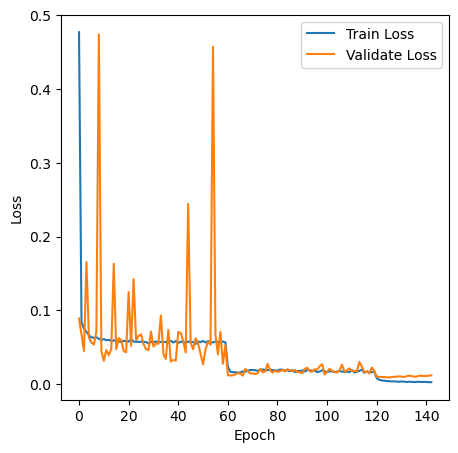

 72%|█████████████████████████████████████████████████████▋                     | 143/200 [9:49:23<3:52:41, 244.94s/it]

Epoch:143
Time:10:00:57.072165
Loss:0.01224140102116647
Total:10000  Correct:9966  CleanAccuracy:0.9966


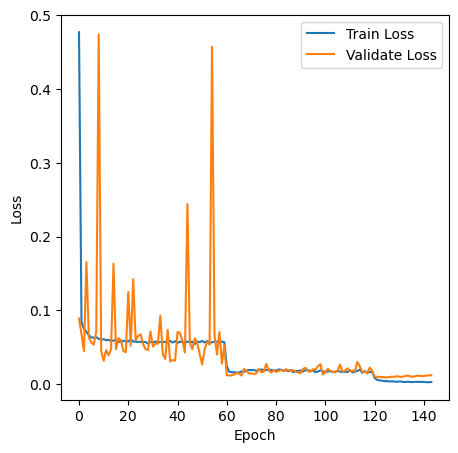

 72%|██████████████████████████████████████████████████████                     | 144/200 [9:53:28<3:48:30, 244.82s/it]

Epoch:144
Time:10:05:02.208412
Loss:0.011345941556272462
Total:10000  Correct:9967  CleanAccuracy:0.9967


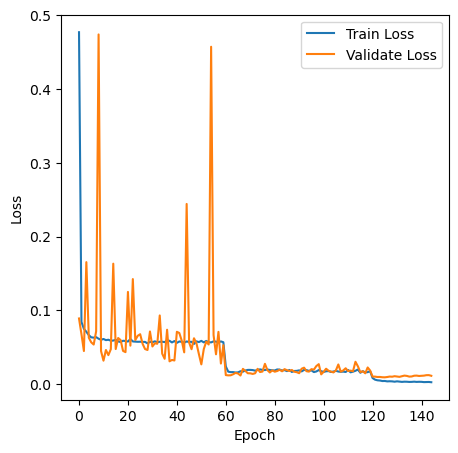

 72%|██████████████████████████████████████████████████████▍                    | 145/200 [9:57:33<3:44:27, 244.87s/it]

Epoch:145
Time:10:09:07.762233
Loss:0.01277811377150819
Total:10000  Correct:9964  CleanAccuracy:0.9964


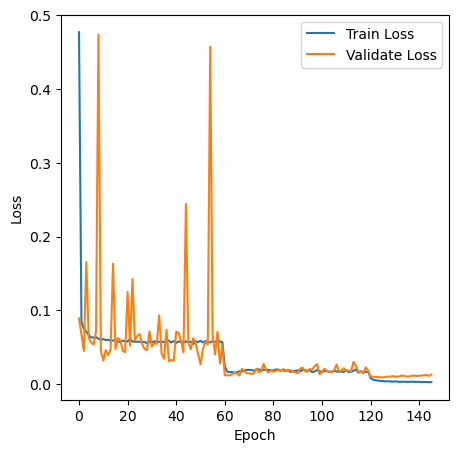

 73%|██████████████████████████████████████████████████████                    | 146/200 [10:01:38<3:40:35, 245.10s/it]

Epoch:146
Time:10:13:12.480425
Loss:0.012168070685063391
Total:10000  Correct:9968  CleanAccuracy:0.9968


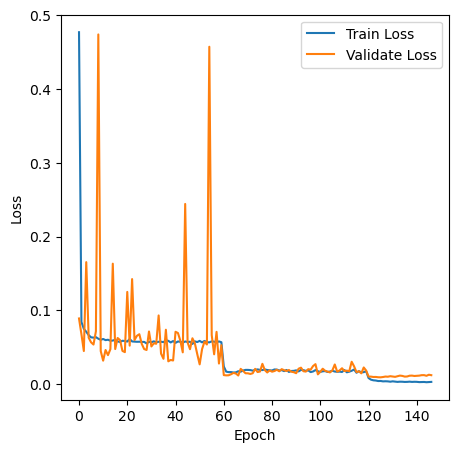

 74%|██████████████████████████████████████████████████████▍                   | 147/200 [10:05:43<3:36:26, 245.02s/it]

Epoch:147
Time:10:17:15.572478
Loss:0.013119903806308373
Total:10000  Correct:9969  CleanAccuracy:0.9969


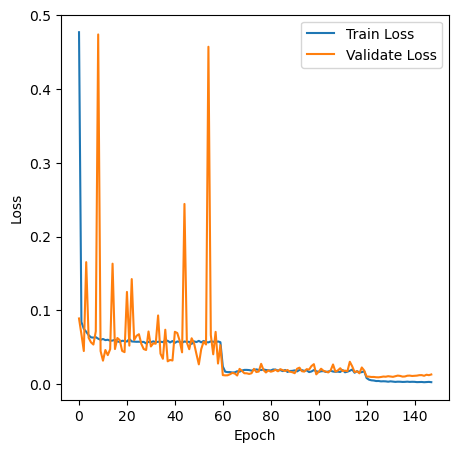

 74%|██████████████████████████████████████████████████████▊                   | 148/200 [10:09:46<3:31:48, 244.40s/it]

Epoch:148
Time:10:21:19.511245
Loss:0.011118172341548561
Total:10000  Correct:9970  CleanAccuracy:0.9970


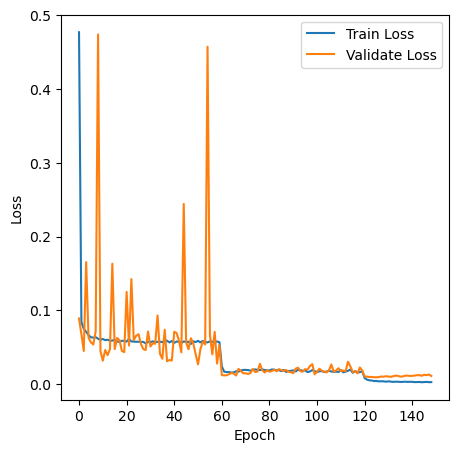

 74%|███████████████████████████████████████████████████████▏                  | 149/200 [10:13:50<3:27:36, 244.25s/it]

Epoch:149
Time:10:25:23.831707
Loss:0.010976099407675263
Total:10000  Correct:9967  CleanAccuracy:0.9967


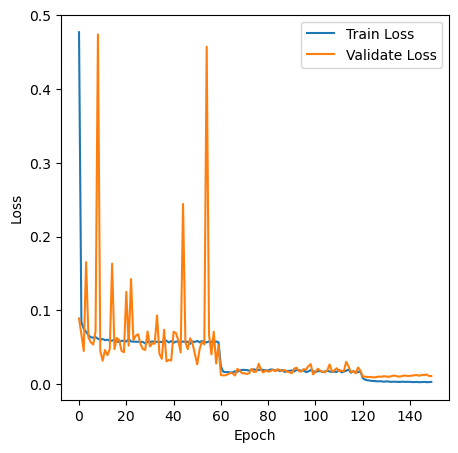

 75%|███████████████████████████████████████████████████████▌                  | 150/200 [10:17:54<3:23:32, 244.26s/it]

Epoch:150
Time:10:29:28.097390
Loss:0.009627285284382966
Total:10000  Correct:9969  CleanAccuracy:0.9969


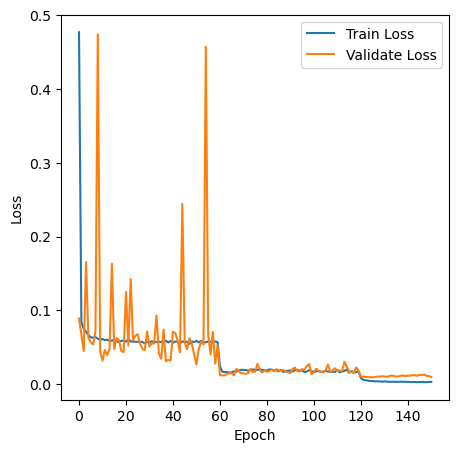

 76%|███████████████████████████████████████████████████████▊                  | 151/200 [10:21:58<3:19:26, 244.22s/it]

Epoch:151
Time:10:33:32.216611
Loss:0.010989590849245365
Total:10000  Correct:9973  CleanAccuracy:0.9973


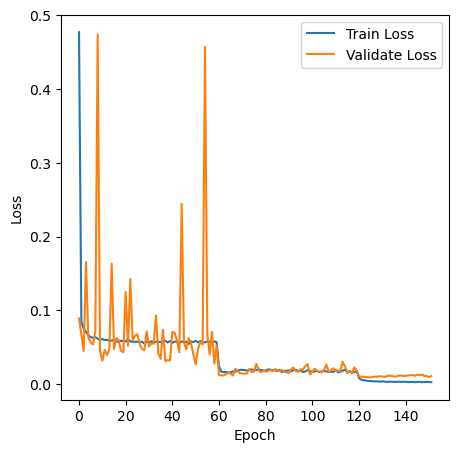

 76%|████████████████████████████████████████████████████████▏                 | 152/200 [10:26:02<3:15:20, 244.17s/it]

Epoch:152
Time:10:37:36.055902
Loss:0.01194045402852747
Total:10000  Correct:9969  CleanAccuracy:0.9969


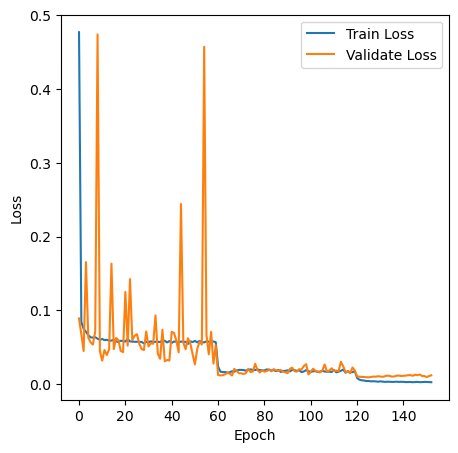

 76%|████████████████████████████████████████████████████████▌                 | 153/200 [10:30:07<3:11:17, 244.21s/it]

Epoch:153
Time:10:41:39.985569
Loss:0.011569496864391961
Total:10000  Correct:9966  CleanAccuracy:0.9966


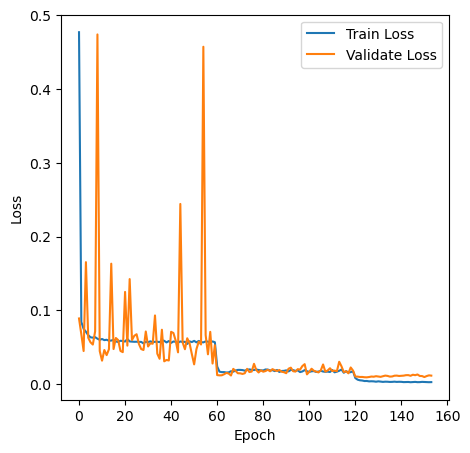

 77%|████████████████████████████████████████████████████████▉                 | 154/200 [10:34:11<3:07:07, 244.09s/it]

Epoch:154
Time:10:45:44.304365
Loss:0.013410714261357289
Total:10000  Correct:9967  CleanAccuracy:0.9967


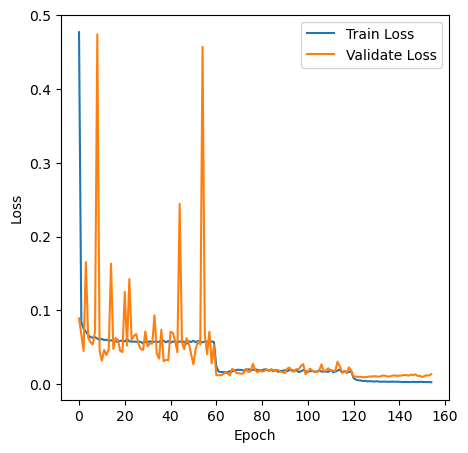

 78%|█████████████████████████████████████████████████████████▎                | 155/200 [10:38:15<3:03:06, 244.14s/it]

Epoch:155
Time:10:49:48.606363
Loss:0.013625217650566226
Total:10000  Correct:9969  CleanAccuracy:0.9969


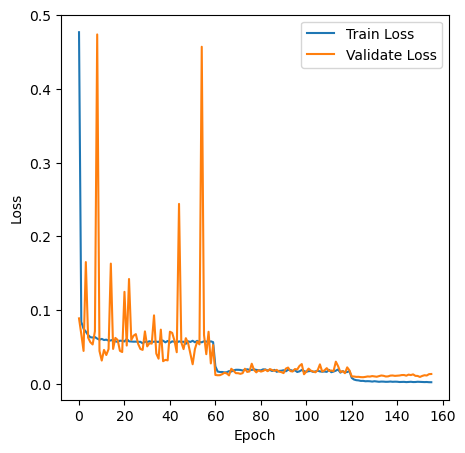

 78%|█████████████████████████████████████████████████████████▋                | 156/200 [10:42:18<2:58:46, 243.77s/it]

Epoch:156
Time:10:53:50.510214
Loss:0.013522959222976928
Total:10000  Correct:9966  CleanAccuracy:0.9966


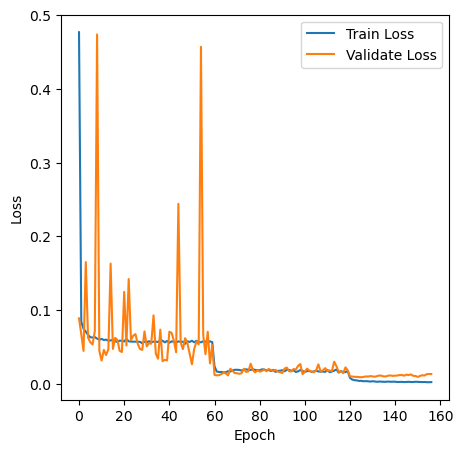

 78%|██████████████████████████████████████████████████████████                | 157/200 [10:46:21<2:54:34, 243.59s/it]

Epoch:157
Time:10:57:55.597966
Loss:0.01557202613838136
Total:10000  Correct:9966  CleanAccuracy:0.9966


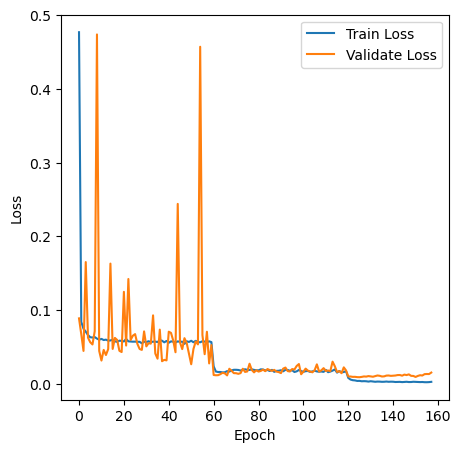

 79%|██████████████████████████████████████████████████████████▍               | 158/200 [10:50:26<2:50:53, 244.13s/it]

Epoch:158
Time:11:02:02.492052
Loss:0.01229218833989794
Total:10000  Correct:9969  CleanAccuracy:0.9969


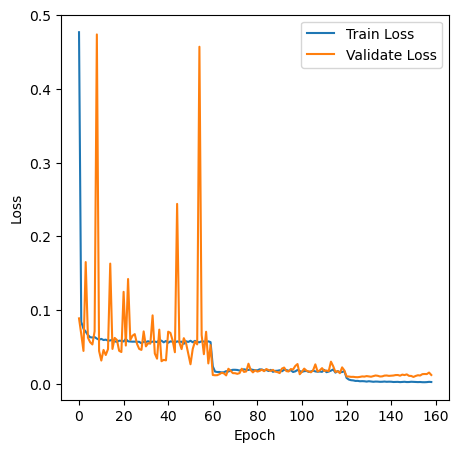

 80%|██████████████████████████████████████████████████████████▊               | 159/200 [10:54:33<2:47:21, 244.92s/it]

Epoch:159
Time:11:06:12.767260
Loss:0.0128339298306399
Total:10000  Correct:9969  CleanAccuracy:0.9969


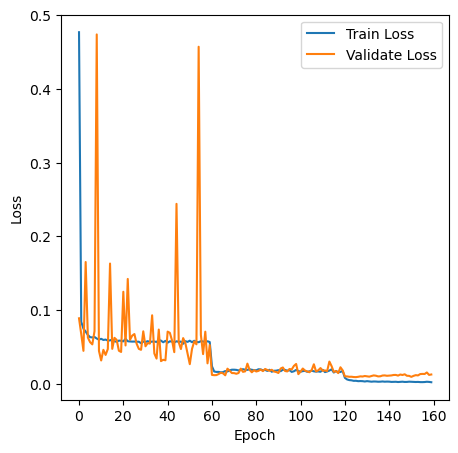

 80%|███████████████████████████████████████████████████████████▏              | 160/200 [10:58:43<2:44:21, 246.54s/it]

Epoch:160
Time:11:10:18.952646
Loss:0.013245693325011517
Total:10000  Correct:9967  CleanAccuracy:0.9967


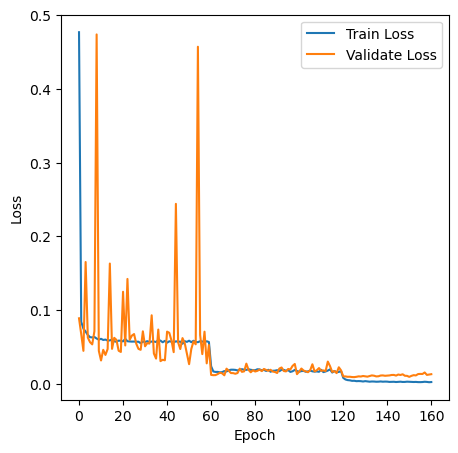

 80%|███████████████████████████████████████████████████████████▌              | 161/200 [11:02:50<2:40:10, 246.43s/it]

Epoch:161
Time:11:14:24.676088
Loss:0.012163908289077457
Total:10000  Correct:9965  CleanAccuracy:0.9965


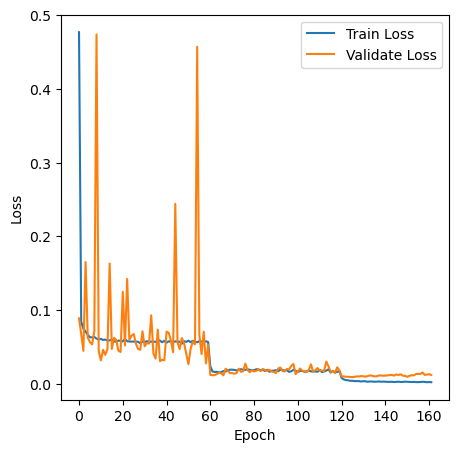

 81%|███████████████████████████████████████████████████████████▉              | 162/200 [11:06:55<2:35:54, 246.16s/it]

Epoch:162
Time:11:18:29.191324
Loss:0.013286111238129889
Total:10000  Correct:9968  CleanAccuracy:0.9968


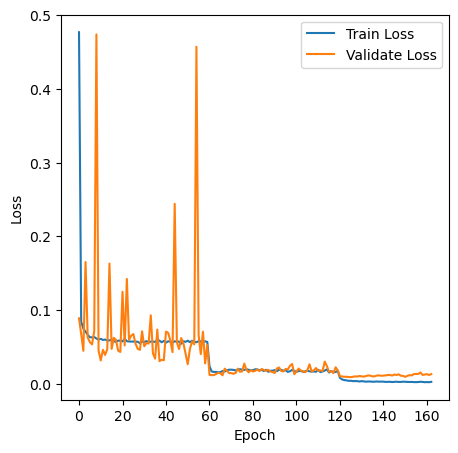

 82%|████████████████████████████████████████████████████████████▎             | 163/200 [11:11:00<2:31:32, 245.74s/it]

Epoch:163
Time:11:22:34.248902
Loss:0.010794658081073421
Total:10000  Correct:9972  CleanAccuracy:0.9972


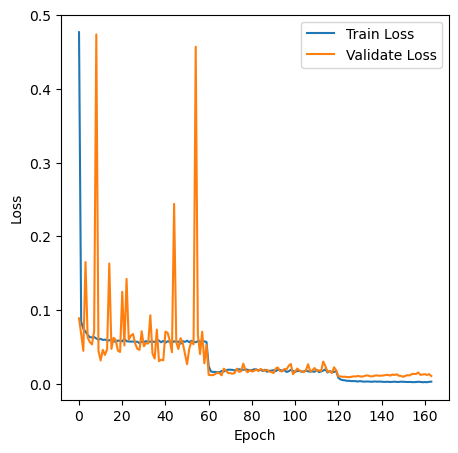

 82%|████████████████████████████████████████████████████████████▋             | 164/200 [11:15:04<2:27:09, 245.25s/it]

Epoch:164
Time:11:26:38.146100
Loss:0.011655612232404562
Total:10000  Correct:9970  CleanAccuracy:0.9970


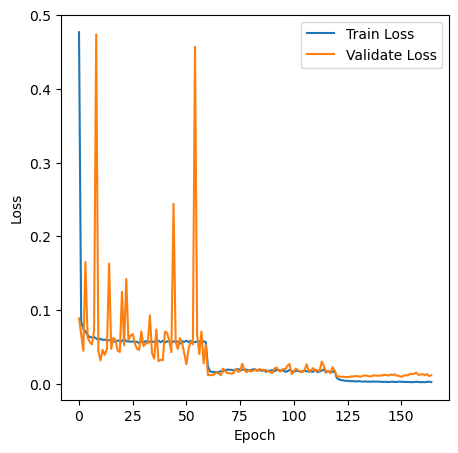

 82%|█████████████████████████████████████████████████████████████             | 165/200 [11:19:09<2:22:59, 245.12s/it]

Epoch:165
Time:11:30:43.035743
Loss:0.01181840909512553
Total:10000  Correct:9966  CleanAccuracy:0.9966


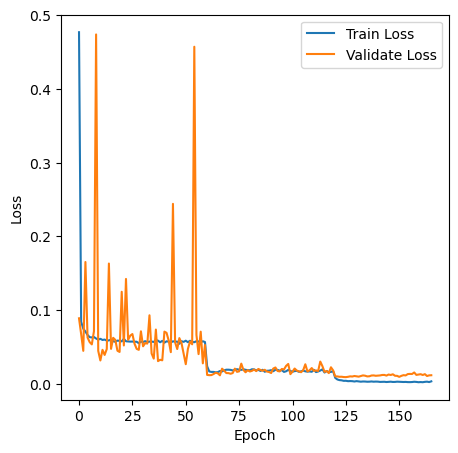

 83%|█████████████████████████████████████████████████████████████▍            | 166/200 [11:23:13<2:18:43, 244.81s/it]

Epoch:166
Time:11:34:46.389518
Loss:0.011302035926214862
Total:10000  Correct:9968  CleanAccuracy:0.9968


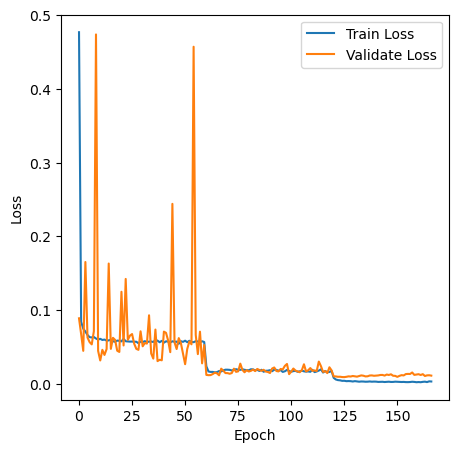

 84%|█████████████████████████████████████████████████████████████▊            | 167/200 [11:27:17<2:14:31, 244.58s/it]

Epoch:167
Time:11:38:56.344950
Loss:0.012488558259867012
Total:10000  Correct:9968  CleanAccuracy:0.9968


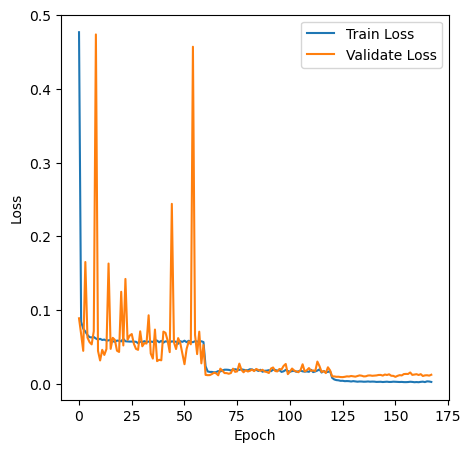

 84%|██████████████████████████████████████████████████████████████▏           | 168/200 [11:31:27<2:11:19, 246.22s/it]

Epoch:168
Time:11:43:02.024805
Loss:0.01395949190754009
Total:10000  Correct:9964  CleanAccuracy:0.9964


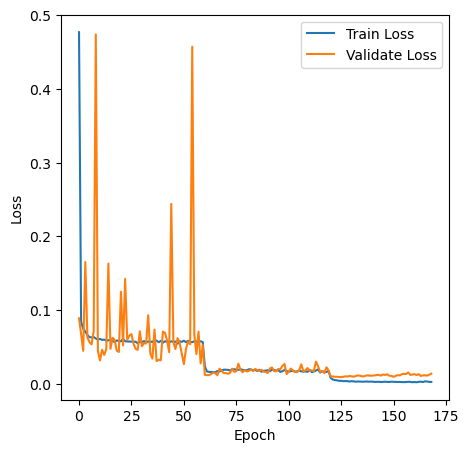

 84%|██████████████████████████████████████████████████████████████▌           | 169/200 [11:35:32<2:07:03, 245.92s/it]

Epoch:169
Time:11:47:05.900306
Loss:0.012284867808791086
Total:10000  Correct:9966  CleanAccuracy:0.9966


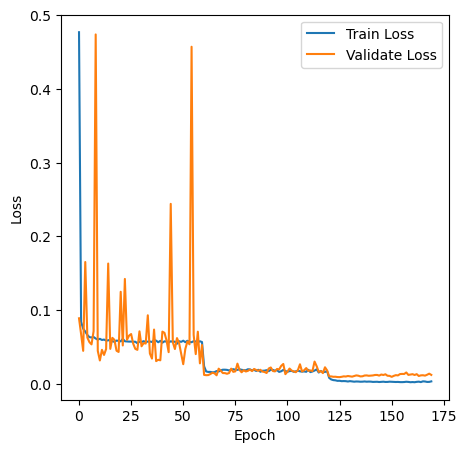

 85%|██████████████████████████████████████████████████████████████▉           | 170/200 [11:39:36<2:02:42, 245.43s/it]

Epoch:170
Time:11:51:10.206763
Loss:0.01075447663388099
Total:10000  Correct:9971  CleanAccuracy:0.9971


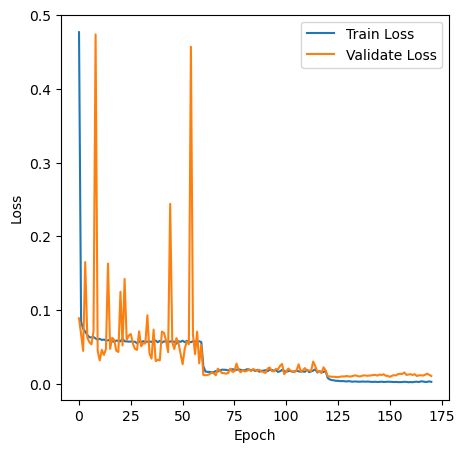

 86%|███████████████████████████████████████████████████████████████▎          | 171/200 [11:43:41<1:58:31, 245.23s/it]

Epoch:171
Time:11:55:16.143448
Loss:0.009622147630382412
Total:10000  Correct:9972  CleanAccuracy:0.9972


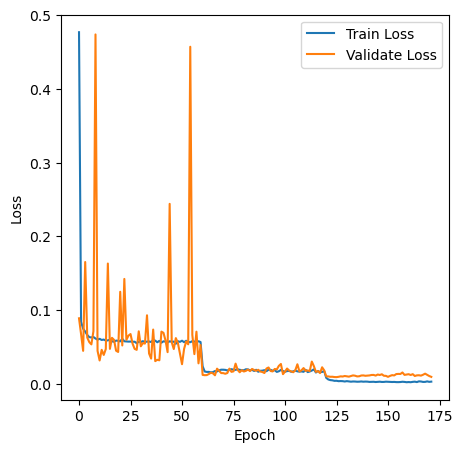

 86%|███████████████████████████████████████████████████████████████▋          | 172/200 [11:47:46<1:54:23, 245.12s/it]

Epoch:172
Time:11:59:20.785782
Loss:0.011596527215042791
Total:10000  Correct:9967  CleanAccuracy:0.9967


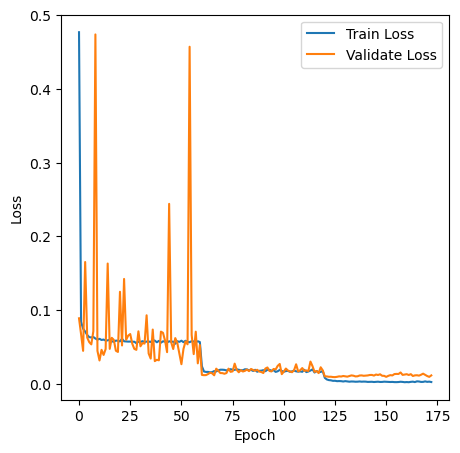

 86%|████████████████████████████████████████████████████████████████          | 173/200 [11:51:51<1:50:18, 245.13s/it]

Epoch:173
Time:12:03:26.621391
Loss:0.01255435685827263
Total:10000  Correct:9971  CleanAccuracy:0.9971


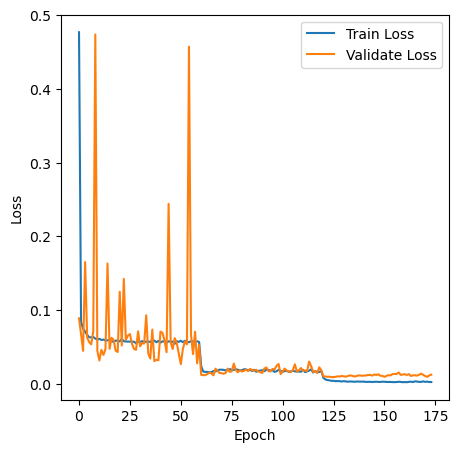

 87%|████████████████████████████████████████████████████████████████▍         | 174/200 [11:55:57<1:46:18, 245.31s/it]

Epoch:174
Time:12:07:31.315182
Loss:0.015173059437586107
Total:10000  Correct:9964  CleanAccuracy:0.9964


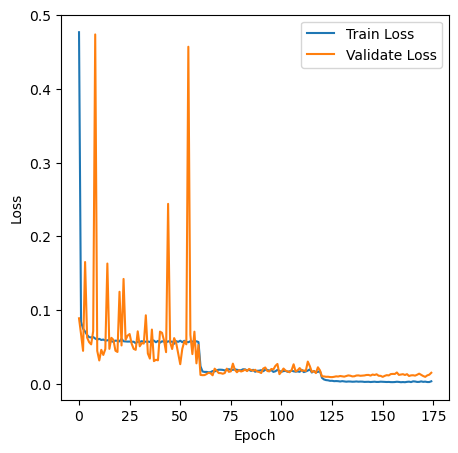

 88%|████████████████████████████████████████████████████████████████▊         | 175/200 [12:00:02<1:42:10, 245.22s/it]

Epoch:175
Time:12:11:36.104976
Loss:0.01508881205773969
Total:10000  Correct:9961  CleanAccuracy:0.9961


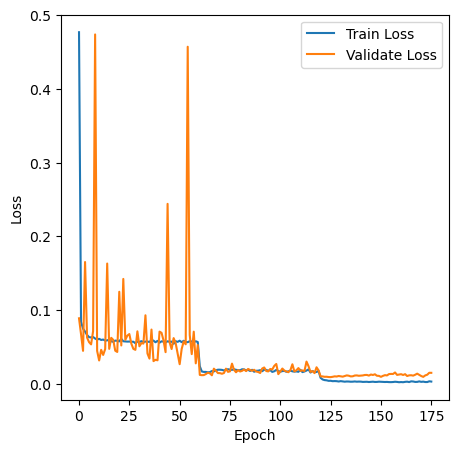

 88%|█████████████████████████████████████████████████████████████████         | 176/200 [12:04:07<1:38:06, 245.26s/it]

Epoch:176
Time:12:16:43.017977
Loss:0.011008022133240137
Total:10000  Correct:9974  CleanAccuracy:0.9974


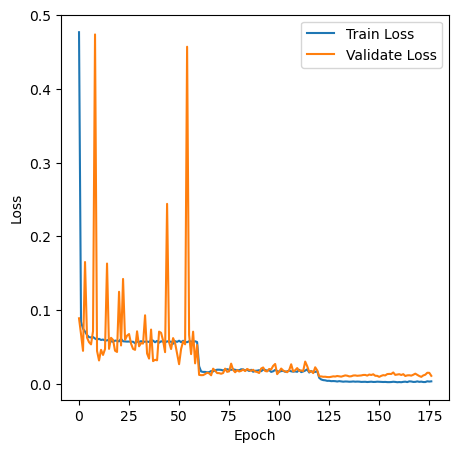

 88%|█████████████████████████████████████████████████████████████████▍        | 177/200 [12:09:15<1:41:13, 264.06s/it]

Epoch:177
Time:12:22:16.297576
Loss:0.01162468811616855
Total:10000  Correct:9967  CleanAccuracy:0.9967


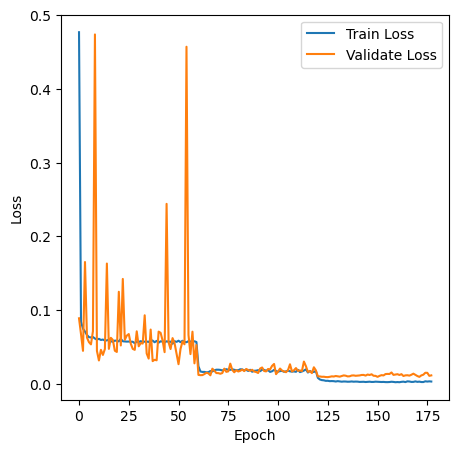

 89%|█████████████████████████████████████████████████████████████████▊        | 178/200 [12:14:48<1:44:21, 284.61s/it]

Epoch:178
Time:12:27:06.031230
Loss:0.015075975528973252
Total:10000  Correct:9963  CleanAccuracy:0.9963


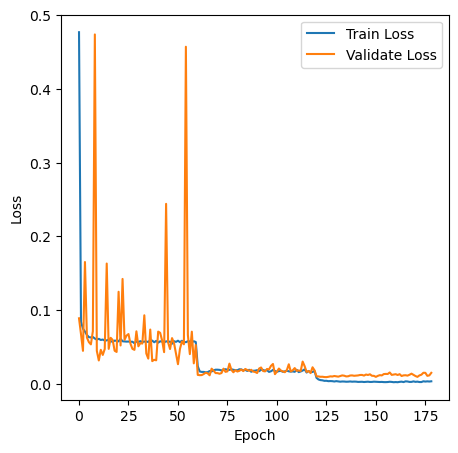

 90%|██████████████████████████████████████████████████████████████████▏       | 179/200 [12:19:37<1:40:03, 285.90s/it]

Epoch:179
Time:12:31:17.278191
Loss:0.011440531826003814
Total:10000  Correct:9971  CleanAccuracy:0.9971


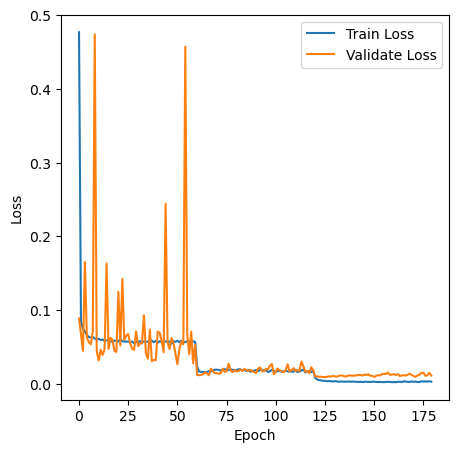

 90%|██████████████████████████████████████████████████████████████████▌       | 180/200 [12:23:47<1:31:45, 275.28s/it]

Epoch:180
Time:12:35:39.802048
Loss:0.012239507693327226
Total:10000  Correct:9971  CleanAccuracy:0.9971


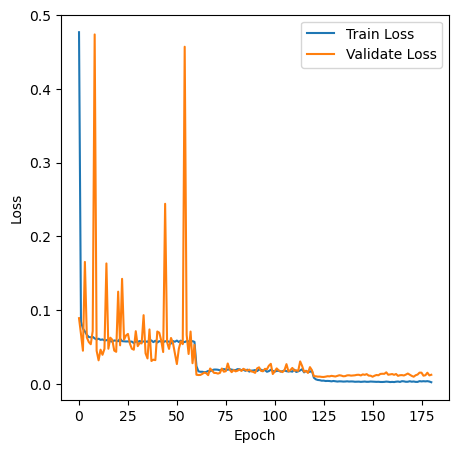

 90%|██████████████████████████████████████████████████████████████████▉       | 181/200 [12:28:10<1:26:01, 271.64s/it]

Epoch:181
Time:12:40:05.818229
Loss:0.012631528264732836
Total:10000  Correct:9970  CleanAccuracy:0.9970


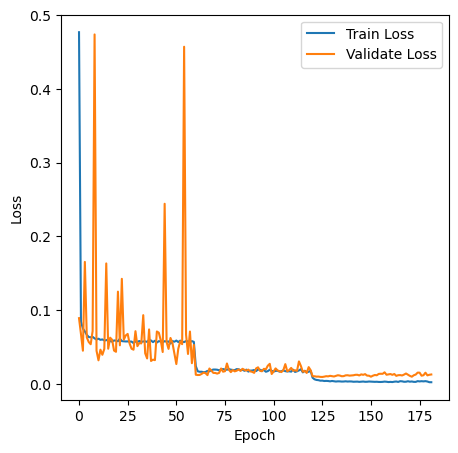

 91%|███████████████████████████████████████████████████████████████████▎      | 182/200 [12:32:36<1:20:55, 269.76s/it]

Epoch:182
Time:12:44:32.289197
Loss:0.012427790485435544
Total:10000  Correct:9969  CleanAccuracy:0.9969


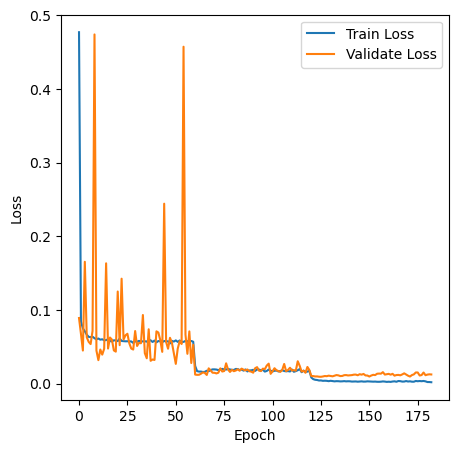

 92%|███████████████████████████████████████████████████████████████████▋      | 183/200 [12:37:02<1:16:07, 268.69s/it]

Epoch:183
Time:12:48:57.788930
Loss:0.012106776170539684
Total:10000  Correct:9971  CleanAccuracy:0.9971


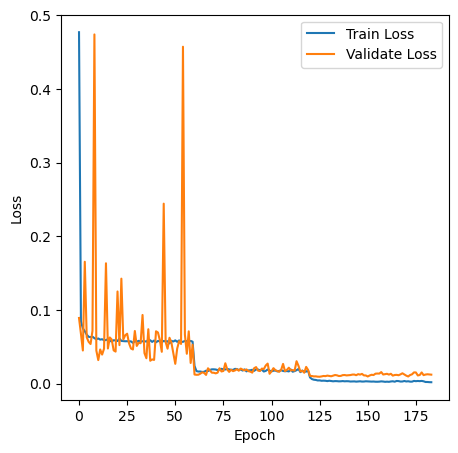

 92%|████████████████████████████████████████████████████████████████████      | 184/200 [12:41:28<1:11:26, 267.88s/it]

Epoch:184
Time:12:53:27.713262
Loss:0.012469441945160243
Total:10000  Correct:9971  CleanAccuracy:0.9971


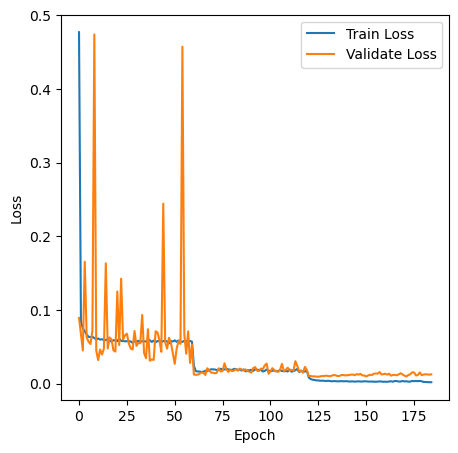

 92%|████████████████████████████████████████████████████████████████████▍     | 185/200 [12:45:58<1:07:09, 268.61s/it]

Epoch:185
Time:12:57:42.392051
Loss:0.012265296337699082
Total:10000  Correct:9970  CleanAccuracy:0.9970


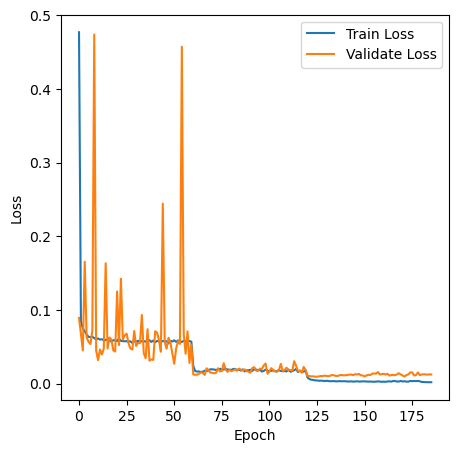

 93%|████████████████████████████████████████████████████████████████████▊     | 186/200 [12:50:13<1:01:40, 264.33s/it]

Epoch:186
Time:13:01:56.859471
Loss:0.011939889391156705
Total:10000  Correct:9972  CleanAccuracy:0.9972


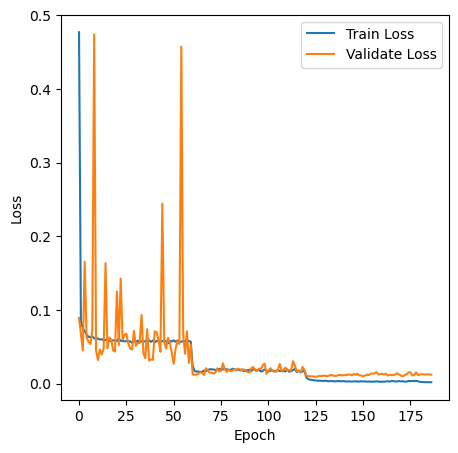

 94%|███████████████████████████████████████████████████████████████████████     | 187/200 [12:54:27<56:39, 261.49s/it]

Epoch:187
Time:13:06:11.690830
Loss:0.012570894926008337
Total:10000  Correct:9970  CleanAccuracy:0.9970


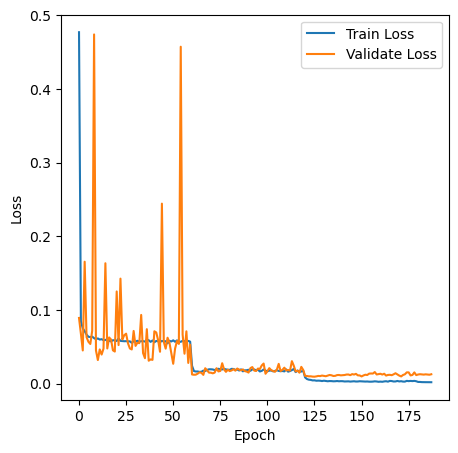

 94%|███████████████████████████████████████████████████████████████████████▍    | 188/200 [12:58:42<51:53, 259.44s/it]

Epoch:188
Time:13:10:24.392639
Loss:0.012055637872444626
Total:10000  Correct:9972  CleanAccuracy:0.9972


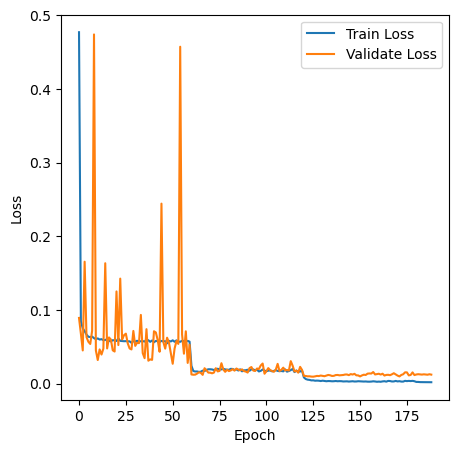

 94%|███████████████████████████████████████████████████████████████████████▊    | 189/200 [13:02:55<47:12, 257.49s/it]

Epoch:189
Time:13:14:39.207517
Loss:0.0126389935289096
Total:10000  Correct:9970  CleanAccuracy:0.9970


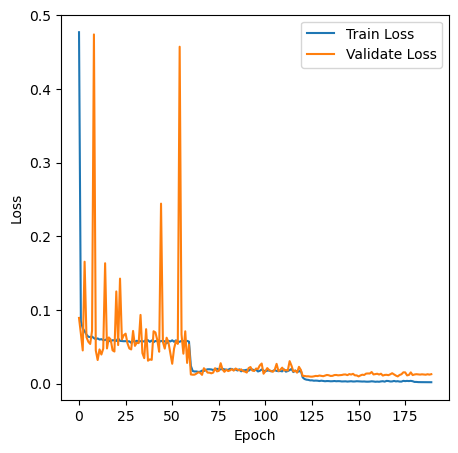

 95%|████████████████████████████████████████████████████████████████████████▏   | 190/200 [13:07:10<42:45, 256.59s/it]

Epoch:190
Time:13:18:50.325061
Loss:0.012653868642640106
Total:10000  Correct:9973  CleanAccuracy:0.9973


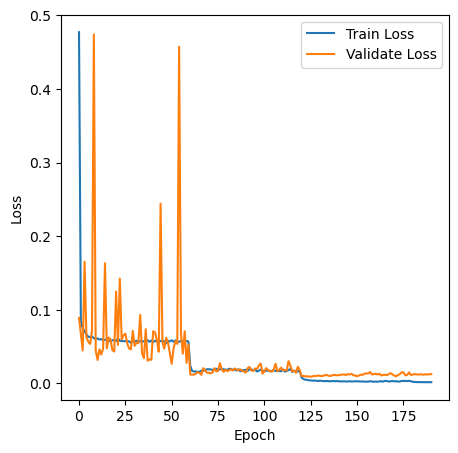

 96%|████████████████████████████████████████████████████████████████████████▌   | 191/200 [13:11:21<38:14, 255.00s/it]

Epoch:191
Time:13:23:04.281730
Loss:0.012449371069074629
Total:10000  Correct:9971  CleanAccuracy:0.9971


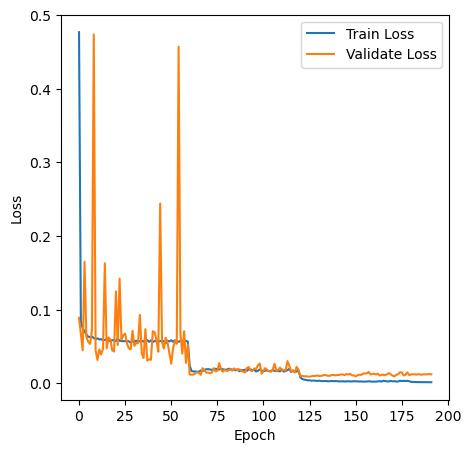

 96%|████████████████████████████████████████████████████████████████████████▉   | 192/200 [13:15:34<33:56, 254.59s/it]

Epoch:192
Time:13:27:18.426219
Loss:0.012249676530032207
Total:10000  Correct:9972  CleanAccuracy:0.9972


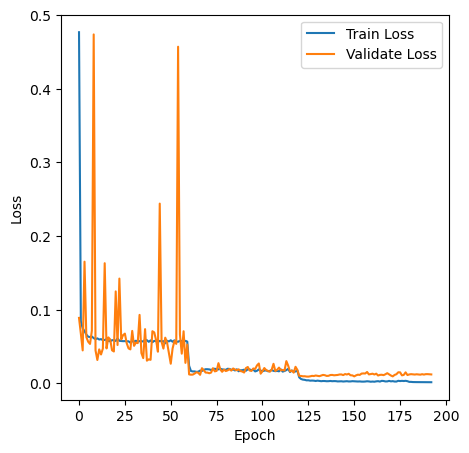

 96%|█████████████████████████████████████████████████████████████████████████▎  | 193/200 [13:19:49<29:41, 254.56s/it]

Epoch:193
Time:13:31:31.472827
Loss:0.012231577177362415
Total:10000  Correct:9971  CleanAccuracy:0.9971


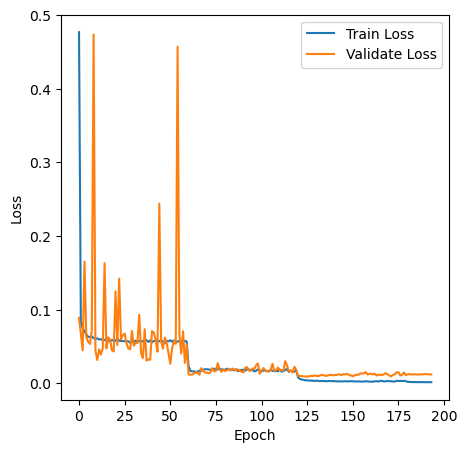

 97%|█████████████████████████████████████████████████████████████████████████▋  | 194/200 [13:24:02<25:23, 253.96s/it]

Epoch:194
Time:13:35:44.166729
Loss:0.012427017676641052
Total:10000  Correct:9970  CleanAccuracy:0.9970


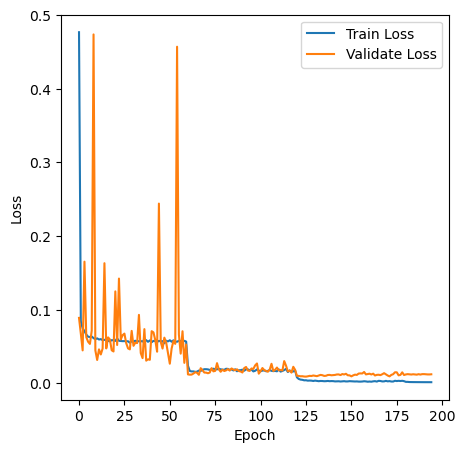

 98%|██████████████████████████████████████████████████████████████████████████  | 195/200 [13:28:14<21:08, 253.64s/it]

Epoch:195
Time:13:39:58.795557
Loss:0.012448920682556154
Total:10000  Correct:9974  CleanAccuracy:0.9974


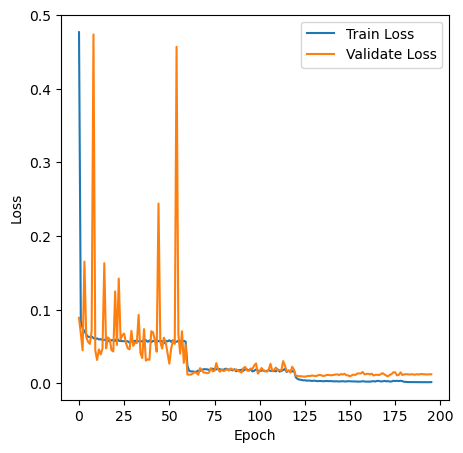

 98%|██████████████████████████████████████████████████████████████████████████▍ | 196/200 [13:32:29<16:55, 253.94s/it]

Epoch:196
Time:13:44:13.121215
Loss:0.012268270385792306
Total:10000  Correct:9971  CleanAccuracy:0.9971


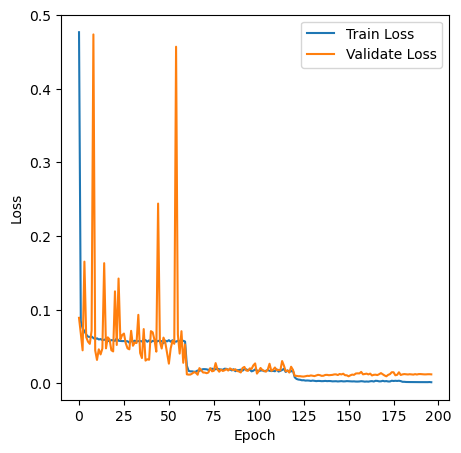

 98%|██████████████████████████████████████████████████████████████████████████▊ | 197/200 [13:36:44<12:42, 254.21s/it]

Epoch:197
Time:13:48:25.123954
Loss:0.01187315833577797
Total:10000  Correct:9974  CleanAccuracy:0.9974


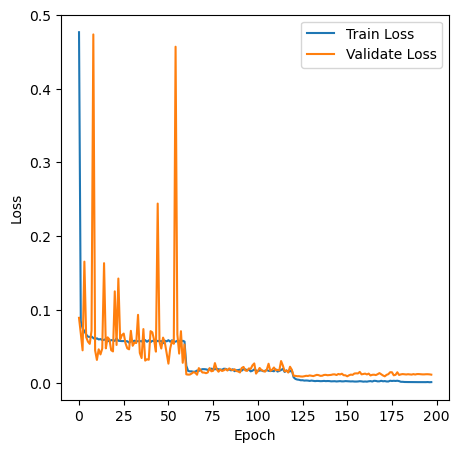

 99%|███████████████████████████████████████████████████████████████████████████▏| 198/200 [13:40:56<08:27, 253.54s/it]

Epoch:198
Time:13:52:39.433620
Loss:0.011953403315947245
Total:10000  Correct:9975  CleanAccuracy:0.9975


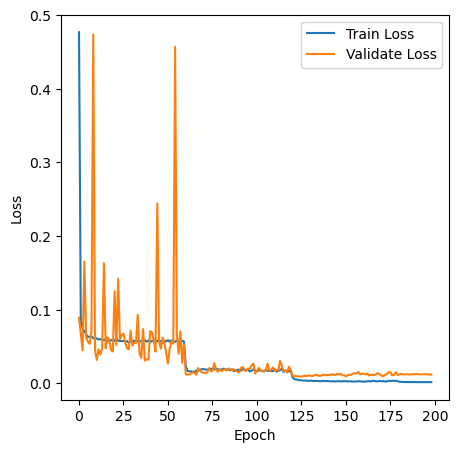

100%|███████████████████████████████████████████████████████████████████████████▌| 199/200 [13:45:10<04:13, 253.74s/it]

Epoch:199
Time:13:56:51.962501
Loss:0.012135807939168339
Total:10000  Correct:9974  CleanAccuracy:0.9974


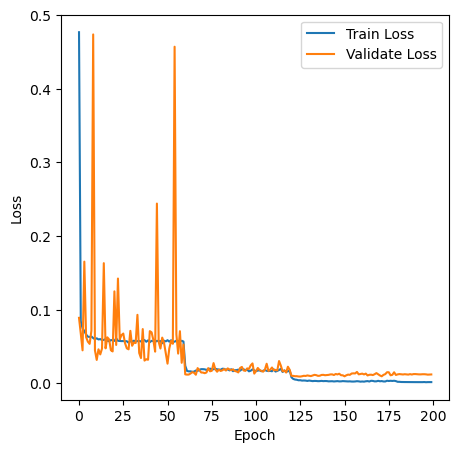

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [13:49:22<00:00, 248.81s/it]


In [9]:
train(model_device=device,
      model=net,
      model_optimizer=optimizer, 
      train_set=train_loader, 
      validate_set=test_loader
)

In [10]:
torch.cuda.empty_cache()